In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn import ensemble, metrics, linear_model
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from kneed import KneeLocator
from matplotlib.ticker import PercentFormatter
import pingouin as pg
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder
import spacy
sp = spacy.load('en_core_web_sm')

In [2]:
# read 2020 procurement data
df_jan_mar_2020 = pd.read_csv(
    'Bid Notice and Award Details Jan-Mar 2020.csv', encoding = "ISO-8859-1")
df_apr_jun_2020 = pd.read_csv(
    'Bid Notice and Award Details Apr-Jun 2020.csv', encoding = "ISO-8859-1")
df_jul_sept_2020 = pd.read_csv(
    'Bid Notice and Award Details Jul-Sep 2020.csv', encoding = "ISO-8859-1")
df_oct_dec_2020 = pd.read_csv(
    'Bid Notice and Award Details Oct-Dec 2020.csv', encoding = "ISO-8859-1")

In [3]:
# combine 2020 data into 1 dataframe
df_proc_2020 = pd.concat([df_jan_mar_2020, df_apr_jun_2020,
                         df_jul_sept_2020, df_oct_dec_2020])

In [4]:
# change reference ID into str
df_proc_2020['Reference ID'] = df_proc_2020['Reference ID'].astype(str)

In [5]:
# make column names of df_proc_2020 consistent
df_jul_sept_2017 = pd.read_csv(
    'Bid Notice and Award Details Jul-Sep 2017.csv', encoding = "ISO-8859-1")
col_names_2017 = df_jul_sept_2017.columns
df_proc_2020.columns = col_names_2017

In [6]:
# combine 2020 data into 1 dataframe
df_proc_2020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 810863 entries, 0 to 236718
Data columns (total 40 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Organization Name                810863 non-null  object 
 1   Reference ID                     810863 non-null  object 
 2   Solicitation No.                 810797 non-null  object 
 3   Notice Title                     810863 non-null  object 
 4   Publish Date                     810863 non-null  object 
 5   Classification                   810863 non-null  object 
 6   Notice Type                      810863 non-null  object 
 7   Business Category                810863 non-null  object 
 8   Funding Source                   810863 non-null  object 
 9   Funding Instrument               810863 non-null  object 
 10  Procurement Mode                 810863 non-null  object 
 11  Trade Agreement                  810863 non-null  object 
 12  Ap

## Clean 2020 Procurement Data

In [7]:
# Change Contract Amount Column of SUC Procurement Data to Numeric Column
df_proc_2020['Contract Amount'] = df_proc_2020[
    'Contract Amount'].replace(',','', regex=True)
df_proc_2020['Contract Amount'] = df_proc_2020[
    'Contract Amount'].replace('-','', regex=True)
df_proc_2020['Contract Amount'] = df_proc_2020[
    'Contract Amount'].replace(' ','', regex=True)
df_proc_2020['Contract Amount'] = df_proc_2020[
    'Contract Amount'].replace('',np.nan, regex=True)
df_proc_2020['Contract Amount'] = df_proc_2020[
    'Contract Amount'].replace('NULL',np.nan, regex=True)
df_proc_2020['Contract Amount'] = df_proc_2020[
    'Contract Amount'].astype(float)

In [8]:
# calculate for Contract Duration to Days Multiplier
# for consistency: 1 month = 30 days: 1 year = 12 months = 360 days
df_proc_2020['Calendar Type'].unique()
num_days = {'Day/s': 1, 'Month/s': 30, 'Year/s': 360, np.nan: 1}
df_proc_2020['Days Multiplier'] = df_proc_2020['Calendar Type']
df_proc_2020['Days Multiplier'] = df_proc_2020[
    'Days Multiplier'].replace(num_days)
df_proc_2020['Contract Duration (Days)'] = df_proc_2020.apply(
    lambda row: (row['Days Multiplier']*row['Contract Duration']), axis=1)

In [9]:
# convert date columns to date time data types
date_cols = ['Publish Date', 'PreBid Date', 'Closing Date', 'Publish '
             'Date(Award)', 'Award Date', 'Notice to Proceed Date', 
             'Contract Efectivity Date', 'Contract End Date']
for i in date_cols:
    df_proc_2020[i] = pd.to_datetime(df_proc_2020[i].str.replace(
        '24:|25:|26:|27:|28:|29:|30:|31:|32:|33:|34:|35:|36:'
        '|37:|38:|39:|40:|41:|42:|43:|44:|45:|46:|47:|48:|49:|'
        '50:|51:|52:|53:|54:|55:|56:|57:|58:|59:','00:'))

<ipython-input-9-8dab1b0d02da>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_proc_2020[i] = pd.to_datetime(df_proc_2020[i].str.replace(


In [10]:
# get difference on dates

# difference (days) between notice to proceed date and publish date
df_proc_2020['Publish-NTP (Days)'] = df_proc_2020[
    'Notice to Proceed Date'] - df_proc_2020['Publish Date']
df_proc_2020['Publish-NTP (Days)'] = pd.to_numeric(df_proc_2020[
    'Publish-NTP (Days)'].dt.days, downcast='integer')

# difference (days) between award date and publish date
df_proc_2020['Publish-Award (Days)'] = df_proc_2020[
    'Award Date'] - df_proc_2020['Publish Date']
df_proc_2020['Publish-Award (Days)'] = pd.to_numeric(df_proc_2020[
    'Publish-Award (Days)'].dt.days, downcast='integer')

# difference (days) between closing date and publish date
df_proc_2020['Publish-Closing (Days)'] = df_proc_2020[
    'Closing Date'] - df_proc_2020['Publish Date']
df_proc_2020['Publish-Closing (Days)'] = pd.to_numeric(df_proc_2020[
    'Publish-Closing (Days)'].dt.days, downcast='integer')

# difference (days) between notice to proceed date and award date
df_proc_2020['Award-NTP (Days)'] = df_proc_2020[
    'Notice to Proceed Date'] - df_proc_2020['Award Date']
df_proc_2020['Award-NTP (Days)'] = pd.to_numeric(df_proc_2020[
    'Award-NTP (Days)'].dt.days, downcast='integer')

In [11]:
# create Year and Quarter Columns
df_proc_2020['Year'] = df_proc_2020['Publish Date'].dt.year
df_proc_2020['Quarter'] = df_proc_2020['Publish Date'].dt.quarter

# change Quarter column into string
df_proc_2020['Quarter'] = df_proc_2020['Quarter'].map({1: '1st', 2: '2nd',
                                                   3: '3rd', 4: '4th'})

In [12]:
# create deep copy of cleaned dataframe
df_proc_2020_clean = df_proc_2020.copy()

In [13]:
# check cleaned dataframe
df_proc_2020_clean.head()

Organization Name Reference ID  \
0  DEPARTMENT OF PUBLIC WORKS AND HIGHWAYS - BENG...      6776642   
1                                PROVINCE OF BATANES      6779335   
2                                PROVINCE OF BATANES      6779368   
3                                PROVINCE OF BATANES      6779402   
4                        DEPARTMENT OF HEALTH - MAIN      6780338   

    Solicitation No.                                       Notice Title  \
0           20PF0030  20PF0030 Convergence and Special Support Progr...   
1  2019-1375-12 (02)  S & D of Construction Materials for the Comple...   
2  2019-1357-11 (02)  S & D of Materials for the Fabrication of Love...   
3  2019-1393-12 (02)  S & D of Construction Materials for the Constr...   
4  IB NO. 2020-042-A  PROCUREMENT OF SERVICE PROVIDER FOR THE HAULIN...   

  Publish Date                    Classification              Notice Type  \
0   2020-01-01                       Civil Works  Invitation to Bid (ITB)   
1   2020-01-01                             Goods  Invitation to Bid (ITB)   
2   2020-01-01                             Goods  Invitation to Bid (ITB)   
3   2020-01-01                             Goods  Invitation to Bid (ITB)   
4   2020-01-01  Goods - General Support Services  Invitation to Bid (ITB)   

                     Business Category                       Funding Source  \
0                Construction Projects  Government of the Philippines (GOP)   
1  Construction Materials and Supplies  Government of the Philippines (GOP)   
2  Construction Materials and Supplies  Government of the Philippines (GOP)   
3  Construction Materials and Supplies  Government of the Philippines (GOP)   
4                             Services  Government of the Philippines (GOP)   

                                  Funding Instrument  ... Reason for Award  \
0  National Expenditure Program (NEP) for the suc...  ...              NaN   
1  Budget for the Contract Approved by the Sanggu...  ...              NaN   
2  Budget for the Contract Approved by the Sanggu...  ...              NaN   
3  Budget for the Contract Approved by the Sanggu...  ...              NaN   
4  National Expenditure Program (NEP) for the suc...  ...              NaN   

  Award Status  Days Multiplier Contract Duration (Days)  Publish-NTP (Days)  \
0          NaN                1                    106.0                 NaN   
1          NaN                1                     30.0                 NaN   
2          NaN                1                     30.0                 NaN   
3          NaN                1                     45.0                 NaN   
4          NaN               30                    360.0                 NaN   

  Publish-Award (Days)  Publish-Closing (Days) Award-NTP (Days)  Year  Quarter  
0                  NaN                    13.0              NaN  2020      1st  
1                  NaN                     7.0              NaN  2020      1st  
2                  NaN                     7.0              NaN  2020      1st  
3                  NaN                     7.0              NaN  2020      1st  
4                  NaN                    21.0              NaN  2020      1st  

[5 rows x 48 columns]

## Prepare 2020 Procurement Data

In [14]:
# check for null values
df_proc_2020_clean.isnull().sum()

Organization Name                       0
Reference ID                            0
Solicitation No.                       66
Notice Title                            0
Publish Date                            0
Classification                          0
Notice Type                             0
Business Category                       0
Funding Source                          0
Funding Instrument                      0
Procurement Mode                        0
Trade Agreement                         0
Approved Budget of the Contract         0
Area of Delivery                    59245
Contract Duration                    3449
Calendar Type                       19540
Line Item No                       367582
Item Name                          367610
Item Desc                          367615
Quantity                           367582
UOM                                367583
Item Budget                        367582
PreBid Date                        597981
Closing Date                      

In [15]:
# replace null values under Area of Delivery with "Others"
df_proc_2020_clean['Area of Delivery'] = df_proc_2020_clean[
    'Area of Delivery'].fillna('Others')

# replace null values under Contract Duration with mean of Contract Duration
# column
df_proc_2020_clean['Contract Duration'] = df_proc_2020_clean[
    'Contract Duration'].fillna(
    value=df_proc_2020_clean['Contract Duration'].mean())

# replace null values under Item Name with "None"
df_proc_2020_clean['Item Name'] = df_proc_2020_clean[
    'Item Name'].fillna('None')

# replace null values under Item Desc with "None"
df_proc_2020_clean['Item Desc'] = df_proc_2020_clean[
    'Item Desc'].fillna('None')

# replace null values under Quantity with mean of Quantity Column
df_proc_2020_clean['Quantity'] = df_proc_2020_clean[
    'Quantity'].fillna(value=df_proc_2020_clean['Quantity'].mean())

# replace null values under Item Budget with mean of Item Budget Column
df_proc_2020_clean['Item Budget'] = df_proc_2020_clean[
    'Item Budget'].fillna(value=df_proc_2020_clean['Item Budget'].mean())

# replace null values under Award Title with "None"
df_proc_2020_clean['Award Title'] = df_proc_2020_clean[
    'Award Title'].fillna('None')

# replace null values under Award Type with "None"
df_proc_2020_clean['Award Type'] = df_proc_2020_clean[
    'Award Type'].fillna('None')

# replace null values under Awardee Corporate Title with "None"
df_proc_2020_clean['Awardee Corporate Title'] = df_proc_2020_clean[
    'Awardee Corporate Title'].fillna('None')

# replace null values under Contract Amount with 0
df_proc_2020_clean['Contract Amount'] = df_proc_2020_clean[
    'Contract Amount'].fillna(0)

# replace null values under Reason for Award with "Not Awarded"
df_proc_2020_clean['Reason for Award'] = df_proc_2020_clean[
    'Reason for Award'].fillna('Not Awarded')

# replace null values under Award Status with "Not Awarded"
df_proc_2020_clean['Award Status'] = df_proc_2020_clean[
    'Award Status'].fillna('Not Awarded')

# replace null values under Contract Duration (Days) with mean of Contract 
# Duration (Days) column
df_proc_2020_clean['Contract Duration (Days)'] = df_proc_2020_clean[
    'Contract Duration (Days)'].fillna(
    value=df_proc_2020_clean['Contract Duration (Days)'].mean())

# replace null values under Publish-NTP (Days) with 0
df_proc_2020_clean['Publish-NTP (Days)'] = df_proc_2020_clean[
    'Publish-NTP (Days)'].fillna(0)

# replace null values under Publish-Award (Days) with 0
df_proc_2020_clean['Publish-Award (Days)'] = df_proc_2020_clean[
    'Publish-Award (Days)'].fillna(0)

# replace null values under Publish-Closing (Days) with 0
df_proc_2020_clean['Publish-Closing (Days)'] = df_proc_2020_clean[
    'Publish-Closing (Days)'].fillna(0)

# replace null values under Publish-Closing (Days) with 0
df_proc_2020_clean['Award-NTP (Days)'] = df_proc_2020_clean[
    'Award-NTP (Days)'].fillna(0)

In [16]:
# check if null values were successfully replaced
df_proc_2020_clean.isnull().sum()

Organization Name                       0
Reference ID                            0
Solicitation No.                       66
Notice Title                            0
Publish Date                            0
Classification                          0
Notice Type                             0
Business Category                       0
Funding Source                          0
Funding Instrument                      0
Procurement Mode                        0
Trade Agreement                         0
Approved Budget of the Contract         0
Area of Delivery                        0
Contract Duration                       0
Calendar Type                       19540
Line Item No                       367582
Item Name                               0
Item Desc                               0
Quantity                                0
UOM                                367583
Item Budget                             0
PreBid Date                        597981
Closing Date                      

In [17]:
# check info of cleaned dataframe
df_proc_2020_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 810863 entries, 0 to 236718
Data columns (total 48 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   Organization Name                810863 non-null  object        
 1   Reference ID                     810863 non-null  object        
 2   Solicitation No.                 810797 non-null  object        
 3   Notice Title                     810863 non-null  object        
 4   Publish Date                     810863 non-null  datetime64[ns]
 5   Classification                   810863 non-null  object        
 6   Notice Type                      810863 non-null  object        
 7   Business Category                810863 non-null  object        
 8   Funding Source                   810863 non-null  object        
 9   Funding Instrument               810863 non-null  object        
 10  Procurement Mode                 810863 non-

In [123]:
df_proc_2020_clean['Award Type'].unique()

array(['None', 'Award Notice  (Shopping - Unforeseen Contingency)',
       'Award Notice',
       'Award Notice (NP - Scientific, Scholarly/Artistic ',
       'Award Notice  (Direct Contracting)',
       'Award Notice (Negotiated Procurement - Agency-to-A',
       'Award Notice (Negotiated Procurement - Emergency C',
       'Negotiated Procurement (Take-over of contracts)',
       'Award Notice (Negotiated Procurement - Highly Tech', 'Re-Award',
       'Negotiated Procurement (Adjacent / Contiguous)', 'Repeat Order',
       'Award Notice (Negotiated Procurement - Defense Coo'], dtype=object)

## Get LGU Data

In [18]:
df_lgu = df_proc_2020_clean[df_proc_2020_clean['Organization Name'].str.contains("CITY OF|PROVINCE OF|MUNICIPALITY OF")]
df_lgu_clean = df_lgu[~df_lgu['Organization Name'].str.contains("DEPARTMENT|BIDS AND AWARDS COMMITTEE|WATER DISTRICT|HIGH SCHOOL|SCHOOL|BARANGAY|BRGY")]
df_lgu_clean

Organization Name Reference ID  \
1                            PROVINCE OF BATANES      6779335   
2                            PROVINCE OF BATANES      6779368   
3                            PROVINCE OF BATANES      6779402   
42                            PROVINCE OF QUEZON      6761508   
44                 MUNICIPALITY OF SAMAL, BATAAN      6773967   
...                                          ...          ...   
236646       MUNICIPALITY OF SALCEDO, ILOCOS SUR      7392763   
236648  MUNICIPALITY OF PAMBUJAN, NORTHERN SAMAR      7392766   
236696         MUNICIPALITY OF NASUGBU, BATANGAS      7392786   
236698         MUNICIPALITY OF NASUGBU, BATANGAS      7392788   
236700         MUNICIPALITY OF NASUGBU, BATANGAS      7392790   

         Solicitation No.                                       Notice Title  \
1       2019-1375-12 (02)  S & D of Construction Materials for the Comple...   
2       2019-1357-11 (02)  S & D of Materials for the Fabrication of Love...   
3       2019-1393-12 (02)  S & D of Construction Materials for the Constr...   
42                9827-19  9827-19 Purchase of Meals for the Year End Pro...   
44                 TF-PCF  Construction of Multi-purpose Hall (Library, M...   
...                   ...                                                ...   
236646    salbac 2020 106  CONSTRUCTION OF CHILD DEVELOPMENT CENTER at Ba...   
236648          21-01-001  Cluster Project Construction of 1-Sty/1-Std Cl...   
236696  Nasugbu 2020-1977        Supply and Delivery of 1 unit of Motorcycle   
236698  Nasugbu 2020-1969  Fabrication/Installation of Christmas Decor an...   
236700  Nasugbu 2020-1973      Supply and Delivery of 5 pcs. Water Dispenser   

       Publish Date Classification                        Notice Type  \
1        2020-01-01          Goods            Invitation to Bid (ITB)   
2        2020-01-01          Goods            Invitation to Bid (ITB)   
3        2020-01-01          Goods            Invitation to Bid (ITB)   
42       2020-01-02          Goods  Notice for Negotiated Procurement   
44       2020-01-02    Civil Works            Invitation to Bid (ITB)   
...             ...            ...                                ...   
236646   2020-12-31    Civil Works            Invitation to Bid (ITB)   
236648   2020-12-31    Civil Works            Invitation to Bid (ITB)   
236696   2020-12-31          Goods        Request for Quotation (RFQ)   
236698   2020-12-31          Goods        Request for Quotation (RFQ)   
236700   2020-12-31          Goods        Request for Quotation (RFQ)   

                          Business Category  \
1       Construction Materials and Supplies   
2       Construction Materials and Supplies   
3       Construction Materials and Supplies   
42                        Catering Services   
44                    Construction Projects   
...                                     ...   
236646                Construction Projects   
236648                Construction Projects   
236696                             Vehicles   
236698  Construction Materials and Supplies   
236700                  General Merchandise   

                             Funding Source  \
1       Government of the Philippines (GOP)   
2       Government of the Philippines (GOP)   
3       Government of the Philippines (GOP)   
42      Government of the Philippines (GOP)   
44      Government of the Philippines (GOP)   
...                                     ...   
236646  Government of the Philippines (GOP)   
236648  Government of the Philippines (GOP)   
236696  Government of the Philippines (GOP)   
236698  Government of the Philippines (GOP)   
236700  Government of the Philippines (GOP)   

                                       Funding Instrument  ...  \
1       Budget for the Contract Approved by the Sanggu...  ...   
2       Budget for the Contract Approved by the Sanggu...  ...   
3       Budget for the Contract Approved by the Sanggu...  ...   
42      Budget for

## EDA for Numeric Data

In [19]:
numeric_eda = ['Organization Name', 'Classification', 'Notice Title', 'Notice Status', 'Approved Budget of the Contract', 'Business Category', 'Award-NTP (Days)', 'Contract Duration (Days)']
df_numeric_eda = df_lgu_clean[numeric_eda]
df_numeric_eda.loc[df_numeric_eda['Notice Status'] == 'Awarded', 'is_Awarded'] = 'Awarded'
df_numeric_eda.loc[df_numeric_eda['Notice Status'] != 'Awarded', 'is_Awarded'] = 'Not Awarded'
df_numeric_eda['Approved Budget of the Contract'] = df_numeric_eda['Approved Budget of the Contract']/1000000
df_numeric_eda

C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-19-47cd26834c9e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Organization Name Classification  \
1                            PROVINCE OF BATANES          Goods   
2                            PROVINCE OF BATANES          Goods   
3                            PROVINCE OF BATANES          Goods   
42                            PROVINCE OF QUEZON          Goods   
44                 MUNICIPALITY OF SAMAL, BATAAN    Civil Works   
...                                          ...            ...   
236646       MUNICIPALITY OF SALCEDO, ILOCOS SUR    Civil Works   
236648  MUNICIPALITY OF PAMBUJAN, NORTHERN SAMAR    Civil Works   
236696         MUNICIPALITY OF NASUGBU, BATANGAS          Goods   
236698         MUNICIPALITY OF NASUGBU, BATANGAS          Goods   
236700         MUNICIPALITY OF NASUGBU, BATANGAS          Goods   

                                             Notice Title Notice Status  \
1       S & D of Construction Materials for the Comple...     Cancelled   
2       S & D of Materials for the Fabrication of Love...     Cancelled   
3       S & D of Construction Materials for the Constr...     Cancelled   
42      9827-19 Purchase of Meals for the Year End Pro...        Closed   
44      Construction of Multi-purpose Hall (Library, M...       Awarded   
...                                                   ...           ...   
236646  CONSTRUCTION OF CHILD DEVELOPMENT CENTER at Ba...        Active   
236648  Cluster Project Construction of 1-Sty/1-Std Cl...        Active   
236696        Supply and Delivery of 1 unit of Motorcycle       Awarded   
236698  Fabrication/Installation of Christmas Decor an...       Awarded   
236700      Supply and Delivery of 5 pcs. Water Dispenser        Closed   

        Approved Budget of the Contract                    Business Category  \
1                              0.056150  Construction Materials and Supplies   
2                              0.102150  Construction Materials and Supplies   
3                              0.367990  Construction Materials and Supplies   
42                             0.160000                    Catering Services   
44                             3.200000                Construction Projects   
...                                 ...                                  ...   
236646                         0.999981                Construction Projects   
236648                         2.074764                Construction Projects   
236696                         0.083052                             Vehicles   
236698                         0.099550  Construction Materials and Supplies   
236700                         0.075000                  General Merchandise   

        Award-NTP (Days)  Contract Duration (Days)   is_Awarded  
1                    0.0                      30.0  Not Awarded  
2                    0.0                      30.0  Not Awarded  
3                    0.0                      45.0  Not Awarded  
42                   0.0                      30.0  Not Awarded  
44                   2.0                      60.0      Awarded  
...                  ...                       ...          ...  
236646               0.0                     100.0  Not Awarded  
236648               0.0                      90.0  Not Awarded  
236696               0.0                      14.0      Awarded  
236698               0.0                      14.0      Awarded  
236700               0.0                       7.0  Not Awarded  

[296220 rows x 9 columns]

In [20]:
df_pareto = pd.DataFrame(df_numeric_eda.groupby('Notice Status').size().sort_values(ascending=False)).reset_index()
df_pareto.columns = ['Notice Status', 'Count']
df_pareto['cumpercentage'] = df_pareto['Count'].cumsum()/df_pareto['Count'].sum()*100

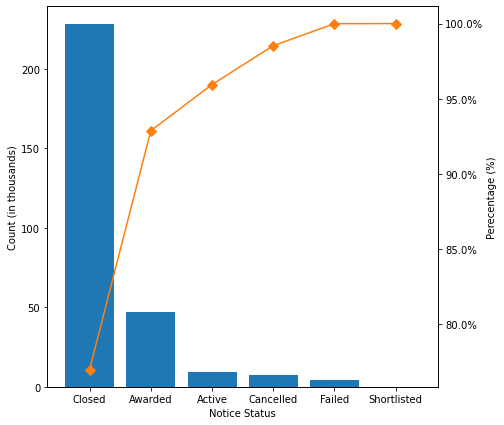

In [21]:
fig, ax = plt.subplots(figsize=(7,7))
ax.bar(df_pareto['Notice Status'], df_pareto['Count']/1000, color="C0")
ax2 = ax.twinx()
ax2.plot(df_pareto['Notice Status'], df_pareto['cumpercentage'], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y")
ax2.tick_params(axis="y")
ax.set_xlabel('Notice Status')
ax.set_ylabel('Count (in thousands)')
ax2.set_ylabel('Perecentage (%)')
plt.show()

In [22]:
df_numeric_eda.groupby('Notice Status').size()

Notice Status
Active           9113
Awarded         47126
Cancelled        7677
Closed         227943
Failed           4336
Shortlisted        25
dtype: int64

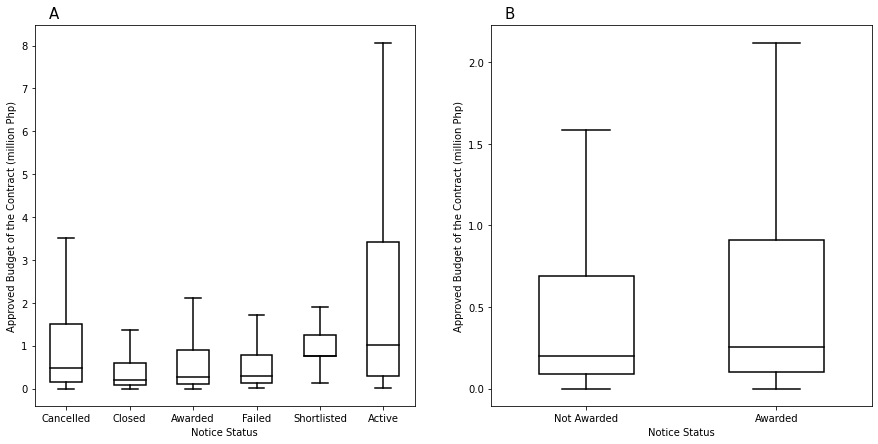

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

a = sns.boxplot(x="Notice Status", y="Approved Budget of the Contract", data=df_numeric_eda, color='white', width=.5, ax=ax[0], showfliers=False)
a.set_xticklabels(a.get_xticklabels())
a.set_ylabel('Approved Budget of the Contract (million Php)')
a.set_xlabel('Notice Status')
a.text(0.05, 1.03, 'A', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=15)
# iterate over boxes
for i,box in enumerate(a.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(5*i,5*(i+1)):
         a.lines[j].set_color('black')

b = sns.boxplot(x="is_Awarded", y="Approved Budget of the Contract", data=df_numeric_eda, color='white', showfliers=False, width=.5, ax=ax[1])
b.set_xticklabels(b.get_xticklabels())
b.set_ylabel('Approved Budget of the Contract (million Php)')
b.set_xlabel('Notice Status')
b.text(0.05, 1.03, 'B', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=15) 
# iterate over boxes
for i,box in enumerate(b.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(5*i,5*(i+1)):
         b.lines[j].set_color('black')

In [24]:
awarded_ABC = df_numeric_eda.loc[df_numeric_eda['is_Awarded']=='Awarded']['Approved Budget of the Contract']
not_awarded_ABC = df_numeric_eda.loc[df_numeric_eda['is_Awarded']=='Not Awarded']['Approved Budget of the Contract']

In [25]:
pg.ttest(not_awarded_ABC, awarded_ABC)

T            dof alternative     p-val           CI95%  \
T-test -2.049007  240972.946457   two-sided  0.040463  [-0.33, -0.01]   

         cohen-d   BF10    power  
T-test  0.005438  0.046  0.19131

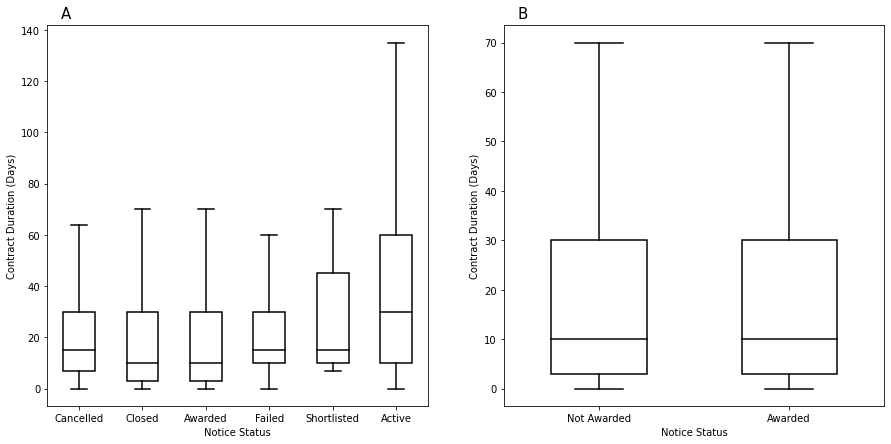

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

a = sns.boxplot(x="Notice Status", y="Contract Duration (Days)", data=df_numeric_eda, color='white', width=.5, ax=ax[0], showfliers=False)
a.set_xticklabels(a.get_xticklabels())
a.set_ylabel('Contract Duration (Days)')
a.set_xlabel('Notice Status')
a.text(0.05, 1.03, 'A', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=15)
# iterate over boxes
for i,box in enumerate(a.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(5*i,5*(i+1)):
         a.lines[j].set_color('black')

b = sns.boxplot(x="is_Awarded", y="Contract Duration (Days)", data=df_numeric_eda, color='white', showfliers=False, width=.5, ax=ax[1])
b.set_xticklabels(b.get_xticklabels())
b.set_ylabel('Contract Duration (Days)')
b.set_xlabel('Notice Status')
b.text(0.05, 1.03, 'B', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=15) 
# iterate over boxes
for i,box in enumerate(b.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(5*i,5*(i+1)):
         b.lines[j].set_color('black')

In [27]:
awarded_CD = df_numeric_eda.loc[df_numeric_eda['is_Awarded']=='Awarded']['Contract Duration (Days)']
not_awarded_CD = df_numeric_eda.loc[df_numeric_eda['is_Awarded']=='Not Awarded']['Contract Duration (Days)']

In [28]:
pg.ttest(not_awarded_CD, awarded_CD)

T           dof alternative     p-val          CI95%   cohen-d  \
T-test -4.518219  48896.020605   two-sided  0.000006  [-6.4, -2.53]  0.042702   

           BF10  power  
T-test  153.398    1.0

In [29]:
df_pareto_class = pd.DataFrame(df_numeric_eda.groupby('Classification').size().sort_values(ascending=False)).reset_index()
df_pareto_class.columns = ['Classification', 'Count']
df_pareto_class['cumpercentage'] = df_pareto_class['Count'].cumsum()/df_pareto_class['Count'].sum()*100

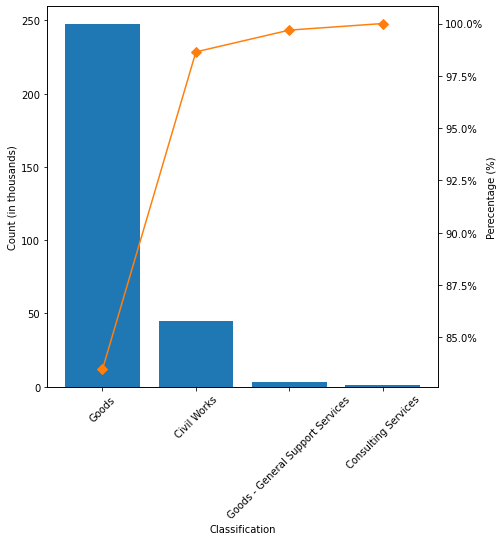

In [30]:
fig, ax = plt.subplots(figsize=(7,7))
ax.bar(df_pareto_class['Classification'], df_pareto_class['Count']/1000, color="C0")
ax.tick_params(axis='x', rotation=45)
ax2 = ax.twinx()
ax2.plot(df_pareto_class['Classification'], df_pareto_class['cumpercentage'], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax.tick_params(axis="y")
ax2.tick_params(axis="y")
ax.set_xlabel('Classification')
ax.set_ylabel('Count (in thousands)')
ax2.set_ylabel('Perecentage (%)')
plt.show()

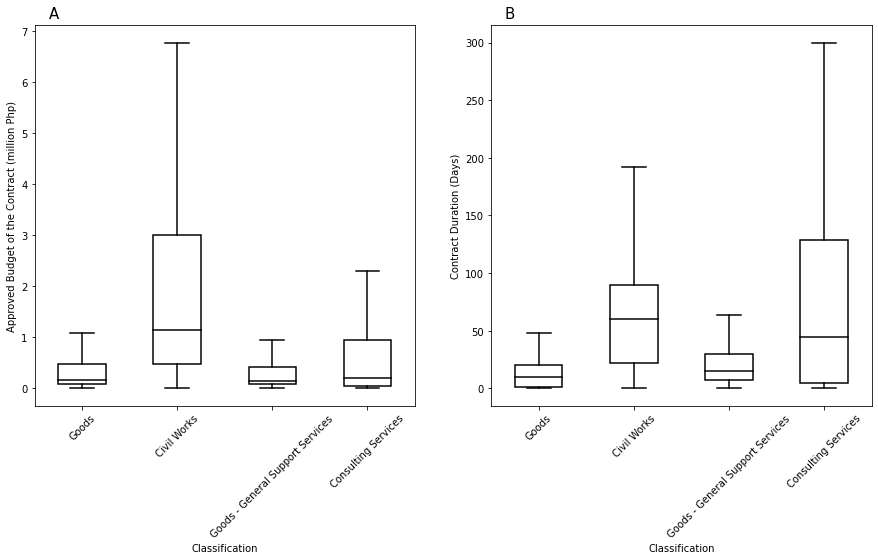

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

a = sns.boxplot(x="Classification", y="Approved Budget of the Contract", data=df_numeric_eda, color='white', width=.5, ax=ax[0], showfliers=False)
a.set_xticklabels(a.get_xticklabels(), rotation=45)
a.set_ylabel('Approved Budget of the Contract (million Php)')
a.set_xlabel('Classification')
a.text(0.05, 1.03, 'A', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=15)
# iterate over boxes
for i,box in enumerate(a.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(5*i,5*(i+1)):
         a.lines[j].set_color('black')

b = sns.boxplot(x="Classification", y="Contract Duration (Days)", data=df_numeric_eda, color='white', showfliers=False, width=.5, ax=ax[1])
b.set_xticklabels(b.get_xticklabels(), rotation=45)
b.set_ylabel('Contract Duration (Days)')
b.set_xlabel('Classification')
b.text(0.05, 1.03, 'B', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=15) 
# iterate over boxes
for i,box in enumerate(b.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(5*i,5*(i+1)):
         b.lines[j].set_color('black')

In [32]:
df_numeric_eda['Approved Budget of the Contract'] = df_numeric_eda['Approved Budget of the Contract']/1000

<ipython-input-32-428f5c378e0a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric_eda['Approved Budget of the Contract'] = df_numeric_eda['Approved Budget of the Contract']/1000


In [33]:
top_10_ABC_ON_eda = pd.DataFrame(df_numeric_eda.groupby(
    'Organization Name')[
    'Approved Budget of the Contract'].sum().sort_values(
    ascending=False)[:10]).reset_index()
top_10_ABC_ON_eda

Organization Name  Approved Budget of the Contract
0                   CITY OF QUEZON                        21.991571
1                   CITY OF MANILA                        19.300418
2  MUNICIPALITY OF ILAGAN, ISABELA                        16.618200
3          CITY OF ANTIPOLO, RIZAL                        14.045724
4           PROVINCE OF PANGASINAN                        12.510729
5                   CITY OF MAKATI                        10.994331
6                    CITY OF PASIG                         9.275092
7                CITY OF LAS PIÑAS                         9.137067
8              PROVINCE OF QUIRINO                         7.938889
9     CITY OF DAVAO, DAVAO DEL SUR                         7.550951

In [34]:
top_10_ABC_ON_percent_eda = pd.DataFrame(df_numeric_eda.groupby(
    'Organization Name')[
    'Approved Budget of the Contract'].sum().sort_values(
    ascending=False)[:10]*100/481.05121540963).reset_index()
top_10_ABC_ON_percent_eda

Organization Name  Approved Budget of the Contract
0                   CITY OF QUEZON                         4.571566
1                   CITY OF MANILA                         4.012134
2  MUNICIPALITY OF ILAGAN, ISABELA                         3.454559
3          CITY OF ANTIPOLO, RIZAL                         2.919798
4           PROVINCE OF PANGASINAN                         2.600706
5                   CITY OF MAKATI                         2.285480
6                    CITY OF PASIG                         1.928088
7                CITY OF LAS PIÑAS                         1.899396
8              PROVINCE OF QUIRINO                         1.650321
9     CITY OF DAVAO, DAVAO DEL SUR                         1.569677

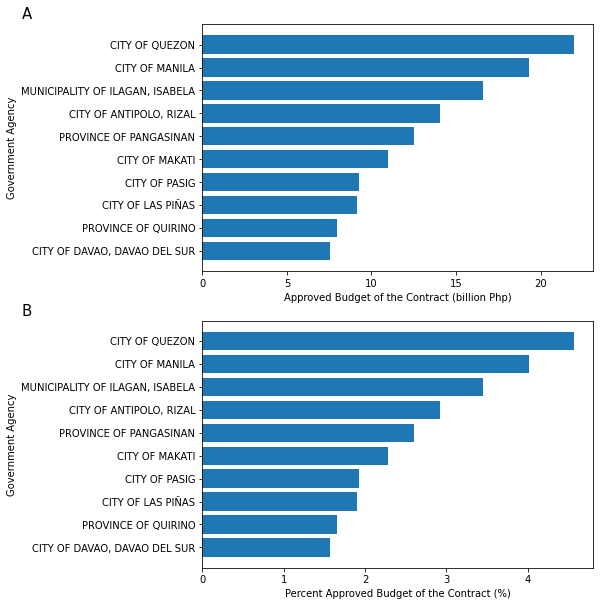

In [35]:
fig, ax = plt.subplots(2, 1, figsize=(7, 10))
ax[0].barh(top_10_ABC_ON_eda['Organization Name'],
        top_10_ABC_ON_eda['Approved Budget of the Contract'], align='center')
ax[0].invert_yaxis()
ax[0].set_xlabel('Approved Budget of the Contract (billion Php)')
ax[0].set_ylabel('Government Agency');
ax[0].text(-0.45, 2.24, 'A', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=15) 
ax[1].barh(top_10_ABC_ON_percent_eda['Organization Name'],
        top_10_ABC_ON_percent_eda['Approved Budget of the Contract'], align='center')
ax[1].invert_yaxis()
ax[1].set_xlabel('Percent Approved Budget of the Contract (%)')
ax[1].set_ylabel('Government Agency');
ax[1].text(-0.45, 1.04, 'B', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=15); 

In [36]:
top_10_ABC_BC_eda = pd.DataFrame(df_numeric_eda.groupby(
    'Business Category')[
    'Approved Budget of the Contract'].sum().sort_values(
    ascending=False)[:10]).reset_index()
top_10_ABC_BC_eda

Business Category  Approved Budget of the Contract
0                       Construction Projects                       206.490431
1                         Drugs and Medicines                        42.461573
2  Medical Supplies and Laboratory Instrument                        23.304862
3                                    Vehicles                        22.018496
4         Construction Materials and Supplies                        17.170538
5                                  Food Stuff                        15.878151
6                                    Services                        14.823628
7                               Grocery Items                        10.368268
8                      Information Technology                         9.720007
9                         General Merchandise                         9.090181

In [37]:
top_10_ABC_BC_percent_eda = pd.DataFrame(df_numeric_eda.groupby(
    'Business Category')[
    'Approved Budget of the Contract'].sum().sort_values(
    ascending=False)[:10]*100/481.05121540963).reset_index()
top_10_ABC_BC_percent_eda

Business Category  Approved Budget of the Contract
0                       Construction Projects                        42.924833
1                         Drugs and Medicines                         8.826830
2  Medical Supplies and Laboratory Instrument                         4.844570
3                                    Vehicles                         4.577163
4         Construction Materials and Supplies                         3.569378
5                                  Food Stuff                         3.300719
6                                    Services                         3.081507
7                               Grocery Items                         2.155336
8                      Information Technology                         2.020576
9                         General Merchandise                         1.889649

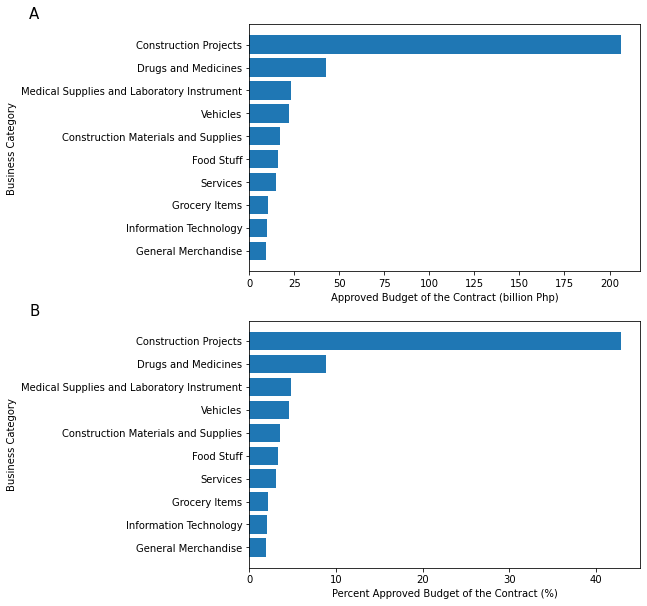

In [38]:
fig, ax = plt.subplots(2, 1, figsize=(7, 10))
ax[0].barh(top_10_ABC_BC_eda['Business Category'],
        top_10_ABC_BC_eda['Approved Budget of the Contract'], align='center')
ax[0].invert_yaxis()
ax[0].set_xlabel('Approved Budget of the Contract (billion Php)')
ax[0].set_ylabel('Business Category');
ax[0].text(-0.55, 2.24, 'A', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=15) 
ax[1].barh(top_10_ABC_BC_percent_eda['Business Category'],
        top_10_ABC_BC_percent_eda['Approved Budget of the Contract'], align='center')
ax[1].invert_yaxis()
ax[1].set_xlabel('Percent Approved Budget of the Contract (%)')
ax[1].set_ylabel('Business Category');
ax[1].text(-0.55, 1.04, 'B', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=15); 

## EDA for Text Data

In [39]:
# extract contract description from columns text from cleaned data
desc = ['Notice Title', 'Item Name', 'Item Desc', 'Award Title',
        'Reason for Award']
df_lgu_clean_desc = df_lgu_clean[desc]

In [40]:
# check df_proc_2020_desc dataframe
df_lgu_clean_desc

Notice Title  \
1       S & D of Construction Materials for the Comple...   
2       S & D of Materials for the Fabrication of Love...   
3       S & D of Construction Materials for the Constr...   
42      9827-19 Purchase of Meals for the Year End Pro...   
44      Construction of Multi-purpose Hall (Library, M...   
...                                                   ...   
236646  CONSTRUCTION OF CHILD DEVELOPMENT CENTER at Ba...   
236648  Cluster Project Construction of 1-Sty/1-Std Cl...   
236696        Supply and Delivery of 1 unit of Motorcycle   
236698  Fabrication/Installation of Christmas Decor an...   
236700      Supply and Delivery of 5 pcs. Water Dispenser   

                                            Item Name  \
1                              Construction Materials   
2                                           Materials   
3                              Construction Materials   
42                                               Food   
44        Construction of Multi-purpose Hall Phase II   
...                                               ...   
236646   Const'n. of Child Devt. Center (Baybayading)   
236648                                           None   
236696       Supply and Delivery of 1 unit Motorcycle   
236698            Construction Materials and Supplies   
236700  Supply and Delivery of 5 pcs. Water Dispenser   

                                                Item Desc  \
1                                                 various   
2                                                 various   
3                                                 various   
42                                       Meals and Snacks   
44      Construction of Multi-purpose Hall (Library, M...   
...                                                   ...   
236646  Spl-1 Removal/Clearing/Layout; I-103 Common/St...   
236648                                               None   
236696  Specs: Model Click 125, Registration date 2020...   
236698  200 bd.ft. Good Lumber 2x2x4', 10 pcs. Marine ...   
236700      Supply and Delivery of 5 pcs. Water Dispenser   

                                        Award Title  \
1                                              None   
2                                              None   
3                                              None   
42                                             None   
44      Construction of Multi-purpose Hall Phase II   
...                                             ...   
236646                                         None   
236648                                         None   
236696     Supply and Delivery of 1 unit Motorcycle   
236698          Construction Materials and Supplies   
236700                                         None   

                        Reason for Award  
1                            Not Awarded  
2                            Not Awarded  
3                            Not Awarded  
42                           Not Awarded  
44      Lowest Calculated Responsive Bid  
...                                  ...  
236646                       Not Awarded  
236648                       Not Awarded  
236696                  lowest quotation  
236698                  lowest quotation  
236700                       Not Awarded  

[296220 rows x 5 columns]

In [41]:
# initialize helper functions
def remove_stopwords(text):
    all_stopwords = sp.Defaults.stop_words
    text = text.lower()
    text_tokens = word_tokenize(text)
    tokens_without_sw = [
        word for word in text_tokens if not word in all_stopwords]
    return ' '.join(tokens_without_sw)

def lemmatize_text(text):
    tokens = text.split()
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return ' '.join(lemmatized_tokens)

def stem_text(text):
    porter_stemmer = PorterStemmer()
    tokens = text.split()
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

def single_vectorizer(df):
    num_vector_features = 300
    tfid = TfidfVectorizer(max_features=num_vector_features)
# why 300?
# [5] CC. Recommender systems. Cham: Springer International Publishing; 2016.
# [6] M. Pazzani and D. Billsus. Learning and revising user profiles: The identification of interesting Web sites. Machine learning, 27(3), pp. 313?331, 1997.
    vector = tfid.fit_transform(df)
    df_vector = pd.DataFrame(
        vector.toarray(), index=df.index, columns=tfid.get_feature_names())
    return df_vector

def quad_vectorizer(df1, df2, df3, df4):
    num_vector_features = 300
    tfid = TfidfVectorizer(max_features=num_vector_features)
# why 300?
# [5] CC. Recommender systems. Cham: Springer International Publishing; 2016.
# [6] M. Pazzani and D. Billsus. Learning and revising user profiles: The identification of interesting Web sites. Machine learning, 27(3), pp. 313?331, 1997.
    vector = tfid.fit_transform(
        df1 + " " + df2 + " " + df3 + " " + df4)
    df_vector = pd.DataFrame(
        vector.toarray(), index=df1.index, columns=tfid.get_feature_names())
    return df_vector

In [42]:
# remove digits
df_lgu_clean_desc = df_lgu_clean_desc.fillna('')
df_lgu_clean_desc['Notice Title'] = df_lgu_clean_desc[
    'Notice Title'].str.replace('\d+', '').astype(str)
df_lgu_clean_desc['Item Name'] = df_lgu_clean_desc[
    'Item Name'].str.replace('\d+', '').astype(str)
df_lgu_clean_desc['Item Desc'] = df_lgu_clean_desc[
    'Item Desc'].str.replace('\d+', '').astype(str)
df_lgu_clean_desc['Award Title'] = df_lgu_clean_desc[
    'Award Title'].str.replace('\d+', '').astype(str)
df_lgu_clean_desc['Reason for Award'] = df_lgu_clean_desc[
    'Reason for Award'].str.replace('\d+', '').astype(str)

<ipython-input-42-0351b03c2d31>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_lgu_clean_desc['Notice Title'] = df_lgu_clean_desc[
<ipython-input-42-0351b03c2d31>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_lgu_clean_desc['Item Name'] = df_lgu_clean_desc[
<ipython-input-42-0351b03c2d31>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df_lgu_clean_desc['Item Desc'] = df_lgu_clean_desc[
<ipython-input-42-0351b03c2d31>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df_lgu_clean_desc['Award Title'] = df_lgu_clean_desc[
<ipython-input-42-0351b03c2d31>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df_lgu_clean_desc['Reason for Award'] = df_lgu_clean_desc[


In [43]:
# remove stop words
df_lgu_clean_desc['Notice Title'] = df_lgu_clean_desc[
    'Notice Title'].apply(remove_stopwords)
df_lgu_clean_desc['Item Name'] = df_lgu_clean_desc['Item Name'].apply(remove_stopwords)
df_lgu_clean_desc['Item Desc'] = df_lgu_clean_desc['Item Desc'].apply(remove_stopwords)
df_lgu_clean_desc['Award Title'] = df_lgu_clean_desc[
    'Award Title'].apply(remove_stopwords)
df_lgu_clean_desc['Reason for Award'] = df_lgu_clean_desc[
    'Reason for Award'].apply(remove_stopwords)

In [44]:
# lemmatize each column
df_lgu_clean_desc['Notice Title'] = df_lgu_clean_desc[
    'Notice Title'].apply(lemmatize_text)
df_lgu_clean_desc['Item Name'] = df_lgu_clean_desc[
    'Item Name'].apply(lemmatize_text)
df_lgu_clean_desc['Item Desc'] = df_lgu_clean_desc[
    'Item Desc'].apply(lemmatize_text)
df_lgu_clean_desc['Award Title'] = df_lgu_clean_desc[
    'Award Title'].apply(lemmatize_text)
df_lgu_clean_desc['Reason for Award'] = df_lgu_clean_desc[
    'Reason for Award'].apply(lemmatize_text)

In [45]:
df_lgu_clean_desc

Notice Title  \
1       s & d construction material completion radiwan...   
2       s & d material fabrication love batanes ( pgo-...   
3       s & d construction material construction/repai...   
42      - purchase meal year end program review orient...   
44      construction multi-purpose hall ( library , mu...   
...                                                   ...   
236646  construction child development center baybayad...   
236648  cluster project construction -sty/-std clsrm s...   
236696                    supply delivery unit motorcycle   
236698  fabrication/installation christmas decor nasug...   
236700               supply delivery pc . water dispenser   

                                            Item Name  \
1                               construction material   
2                                            material   
3                               construction material   
42                                               food   
44           construction multi-purpose hall phase ii   
...                                               ...   
236646  const'n . child devt . center ( baybayading )   
236648                                                  
236696                supply delivery unit motorcycle   
236698                   construction material supply   
236700           supply delivery pc . water dispenser   

                                                Item Desc  \
1                                                           
2                                                           
3                                                           
42                                             meal snack   
44      construction multi-purpose hall ( library , mu...   
...                                                   ...   
236646  spl- removal/clearing/layout ; i- common/struc...   
236648                                                      
236696  spec : model click , registration date , trans...   
236698  bd.ft . good lumber xx ' , pc . marine plywood...   
236700               supply delivery pc . water dispenser   

                                     Award Title  \
1                                                  
2                                                  
3                                                  
42                                                 
44      construction multi-purpose hall phase ii   
...                                          ...   
236646                                             
236648                                             
236696           supply delivery unit motorcycle   
236698              construction material supply   
236700                                             

                        Reason for Award  
1                                awarded  
2                                awarded  
3                                awarded  
42                               awarded  
44      lowest calculated responsive bid  
...                                  ...  
236646                           awarded  
236648                           awarded  
236696                  lowest quotation  
236698                  lowest quotation  
236700                           awarded  

[296220 rows x 5 columns]

In [46]:
df_lgu_clean_desc['Combined_Contract_Details'] = df_lgu_clean_desc['Notice Title'] + ' ' + df_lgu_clean_desc['Item Name'] + ' ' + df_lgu_clean_desc['Item Desc'] + ' ' + df_lgu_clean_desc['Award Title']
df_lgu_clean_desc

Notice Title  \
1       s & d construction material completion radiwan...   
2       s & d material fabrication love batanes ( pgo-...   
3       s & d construction material construction/repai...   
42      - purchase meal year end program review orient...   
44      construction multi-purpose hall ( library , mu...   
...                                                   ...   
236646  construction child development center baybayad...   
236648  cluster project construction -sty/-std clsrm s...   
236696                    supply delivery unit motorcycle   
236698  fabrication/installation christmas decor nasug...   
236700               supply delivery pc . water dispenser   

                                            Item Name  \
1                               construction material   
2                                            material   
3                               construction material   
42                                               food   
44           construction multi-purpose hall phase ii   
...                                               ...   
236646  const'n . child devt . center ( baybayading )   
236648                                                  
236696                supply delivery unit motorcycle   
236698                   construction material supply   
236700           supply delivery pc . water dispenser   

                                                Item Desc  \
1                                                           
2                                                           
3                                                           
42                                             meal snack   
44      construction multi-purpose hall ( library , mu...   
...                                                   ...   
236646  spl- removal/clearing/layout ; i- common/struc...   
236648                                                      
236696  spec : model click , registration date , trans...   
236698  bd.ft . good lumber xx ' , pc . marine plywood...   
236700               supply delivery pc . water dispenser   

                                     Award Title  \
1                                                  
2                                                  
3                                                  
42                                                 
44      construction multi-purpose hall phase ii   
...                                          ...   
236646                                             
236648                                             
236696           supply delivery unit motorcycle   
236698              construction material supply   
236700                                             

                        Reason for Award  \
1                                awarded   
2                                awarded   
3                                awarded   
42                               awarded   
44      lowest calculated responsive bid   
...                                  ...   
236646                           awarded   
236648                           awarded   
236696                  lowest quotation   
236698                  lowest quotation   
236700                           awarded   

                                Combined_Contract_Details  
1       s & d construction material completion radiwan...  
2       s & d material fabrication love batanes ( pgo-...  
3       s & d construction material construction/repai...  
42      - purchase meal year end program review orient...  
44      construction multi-purpose hall ( library , mu...  
...                                                   ...  
236646  construction child development center baybayad...  
236648  cluster project construction -sty/-std clsrm s...  
236696  supply delivery unit motorcycle supply deliver...  
236698  fabrication/installation christmas decor nasug...  
236700  supply delivery pc . water dispenser supply de...  

[296220 rows x 6 co

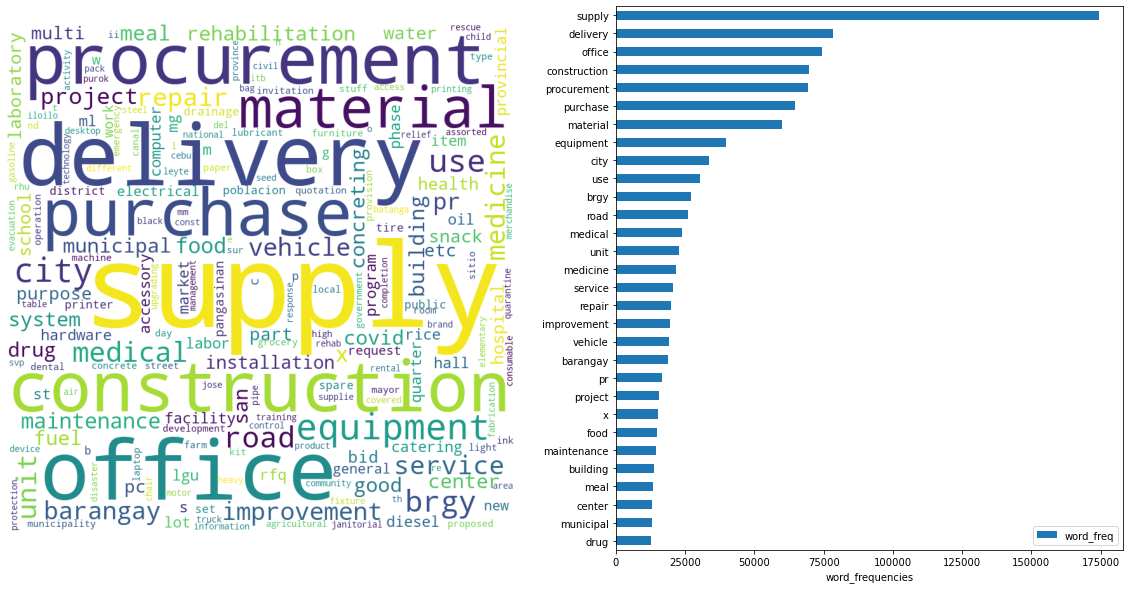

In [47]:
# create wordcloud
contract_details_text = ' '.join(df_lgu_clean_desc['Combined_Contract_Details'])
wordcloud_contract_details = WordCloud(
    width = 800, height = 800,
    background_color ='white',
    max_words=200,
    collocations = False).generate(contract_details_text)

# create word frequencies
wordcloud_freq_contract_details = WordCloud(collocations = False).process_text(contract_details_text)
dict_freq = dict(sorted(
    wordcloud_freq_contract_details.items(), key=lambda item: item[1], reverse=True))
top_30_freq = {k: dict_freq[k] for k in list(dict_freq)[:30]}
top_30_freq_df = pd.DataFrame.from_dict(
    top_30_freq, orient='index', columns=['word_freq'])

# generate plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(wordcloud_contract_details)
ax1.axis("off")
ax2 = top_30_freq_df.plot(kind='barh', ax=ax2)
ax2.set_xlabel('word_frequencies')
ax2.invert_yaxis()
plt.show()

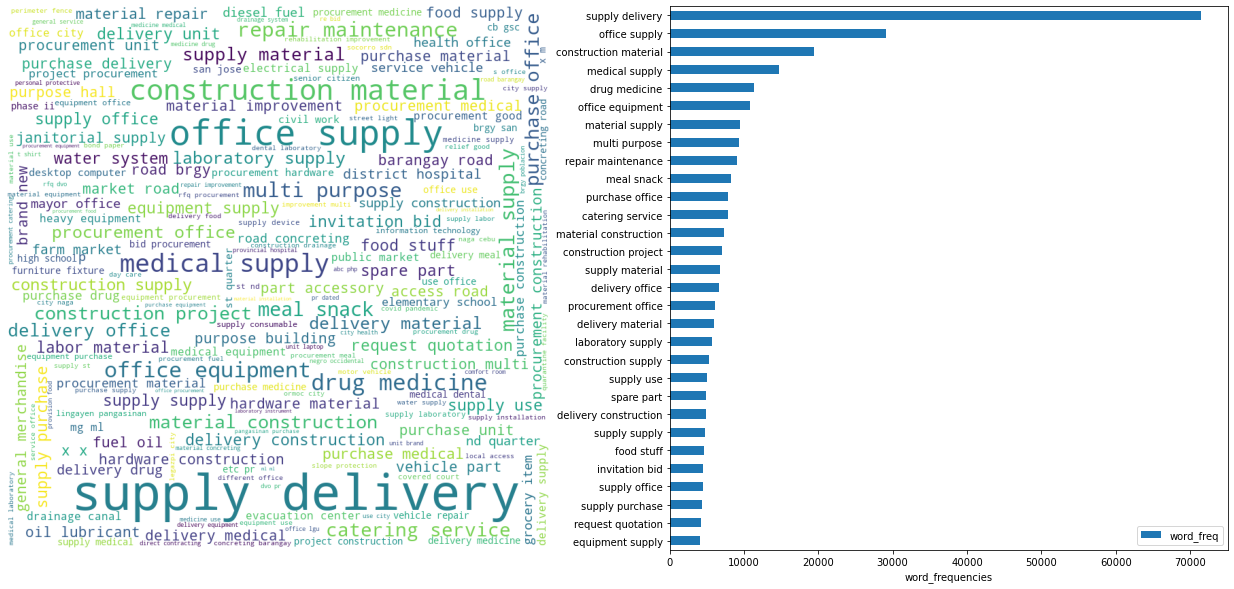

In [48]:
# create wordcloud
contract_details_text = ' '.join(df_lgu_clean_desc['Combined_Contract_Details'])
wordcloud_contract_details = WordCloud(
    width = 800, height = 800,
    background_color ='white',
    max_words=200,
    collocations = True).generate(contract_details_text)

# create word frequencies
wordcloud_freq_contract_details = WordCloud(collocations = True).process_text(contract_details_text)
dict_freq = dict(sorted(
    wordcloud_freq_contract_details.items(), key=lambda item: item[1], reverse=True))
top_30_freq = {k: dict_freq[k] for k in list(dict_freq)[:30]}
top_30_freq_df = pd.DataFrame.from_dict(
    top_30_freq, orient='index', columns=['word_freq'])

# generate plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(22,10))
ax1.imshow(wordcloud_contract_details)
ax1.axis("off")
ax2 = top_30_freq_df.plot(kind='barh', ax=ax2)
ax2.set_xlabel('word_frequencies')
ax2.invert_yaxis()
plt.show()

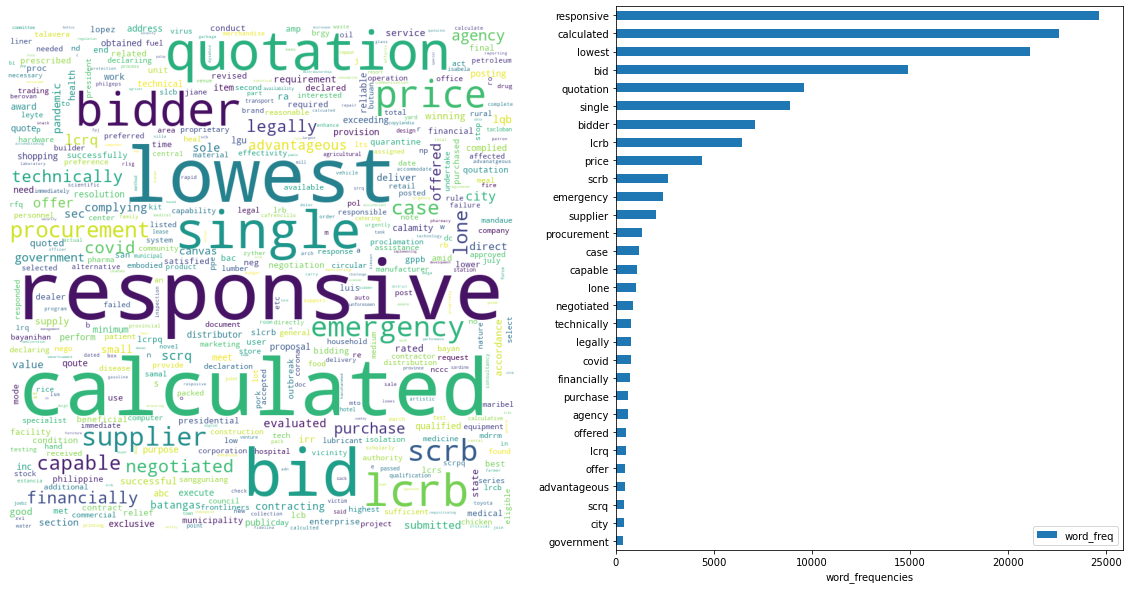

In [49]:
# create wordcloud
reason_for_award_text = ' '.join(df_lgu_clean_desc['Reason for Award'])
wordcloud_reason_for_award = WordCloud(
    width = 800, height = 800,
    background_color ='white',
    max_words=500,
    collocations = False, stopwords=['awarded']).generate(reason_for_award_text)

# create word frequencies
wordcloud_freq_reason_for_award = WordCloud(collocations = False, stopwords=['awarded']).process_text(reason_for_award_text)
dict_freq = dict(sorted(
    wordcloud_freq_reason_for_award.items(), key=lambda item: item[1], reverse=True))
top_30_freq = {k: dict_freq[k] for k in list(dict_freq)[:30]}
top_30_freq_df = pd.DataFrame.from_dict(
    top_30_freq, orient='index', columns=['word_freq'])

# generate plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(wordcloud_reason_for_award)
ax1.axis("off")
ax2 = top_30_freq_df.plot(kind='barh', ax=ax2)
ax2.set_xlabel('word_frequencies')
ax2.invert_yaxis()
plt.show()

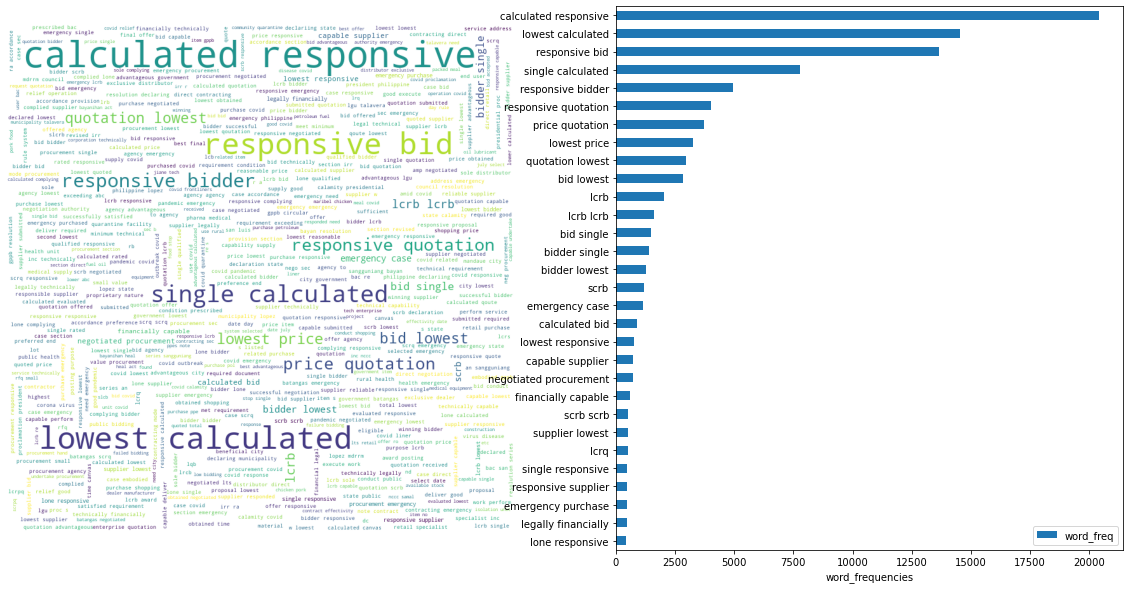

In [50]:
# create wordcloud
reason_for_award_text = ' '.join(df_lgu_clean_desc['Reason for Award'])
wordcloud_reason_for_award = WordCloud(
    width = 800, height = 800,
    background_color ='white',
    max_words=500,
    collocations = True, stopwords=['awarded']).generate(reason_for_award_text)

# create word frequencies
wordcloud_freq_reason_for_award = WordCloud(collocations = True,stopwords=['awarded']).process_text(reason_for_award_text)
dict_freq = dict(sorted(
    wordcloud_freq_reason_for_award.items(), key=lambda item: item[1], reverse=True))
top_30_freq = {k: dict_freq[k] for k in list(dict_freq)[:30]}
top_30_freq_df = pd.DataFrame.from_dict(
    top_30_freq, orient='index', columns=['word_freq'])

# generate plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(wordcloud_reason_for_award)
ax1.axis("off")
ax2 = top_30_freq_df.plot(kind='barh', ax=ax2)
ax2.set_xlabel('word_frequencies')
ax2.invert_yaxis()
plt.show()

## COVID-19 Contracts Numeric EDA

In [67]:
df_covid = df_lgu_clean[(df_lgu_clean['Notice Title'].str.contains("COVID|Covid|covid")) | df_lgu_clean['Item Name'].str.contains("COVID|Covid|covid") | df_lgu_clean['Item Desc'].str.contains("COVID|Covid|covid") | df_lgu_clean['Award Title'].str.contains("COVID|Covid|covid") | df_lgu_clean['Reason for Award'].str.contains("COVID|Covid|covid")]
df_covid

Organization Name Reference ID  \
110922             MUNICIPALITY OF GUBAT, SORSOGON      6866060   
110993                  CITY OF SORSOGON, SORSOGON      6866134   
110994                  CITY OF SORSOGON, SORSOGON      6866134   
114703    MUNICIPALITY OF TOBIAS FORNIER,  ANTIQUE      6867696   
133320         MUNICIPALITY OF SAN FRANCISCO, CEBU      6882443   
...                                            ...          ...   
235953             CITY OF BAYUGAN, AGUSAN DEL SUR      7392134   
236074         MUNICIPALITY OF MABALACAT, PAMPANGA      7392281   
236211                    PROVINCE OF ILOCOS NORTE      7392049   
236219  MUNICIPALITY OF LAPUYAN, ZAMBOANGA DEL SUR      7392527   
236327                  PROVINCE OF AGUSAN DEL SUR      7392389   

       Solicitation No.                                       Notice Title  \
110922         PR-10684                      PPE'S FOR COVID-19 PREVENTION   
110993    SVP-20-02-076  PROCUREMENT OF HAND SANITIZER(ALCOHOL) AND DES...   
110994    SVP-20-02-076  PROCUREMENT OF HAND SANITIZER(ALCOHOL) AND DES...   
114703         2020-012     Emergency Purchase for the Prevention of COVID   
133320         046-2020  TO BE USED FOR EMERGENCY MEDICAL SUPPLIES FOR ...   
...                 ...                                                ...   
235953         1229-001  Supply and Delivery of Catering Services for T...   
236074    20201229-04-G  Procurement of Acrylic Barrier for the use of ...   
236211      9998-20-115  Supply and Delivery of Rapid Diagnostic Test K...   
236219      2020-12-222  PROCUREMENT OF MEALS FOR THE LSI IN THE MUNICI...   
236327       21-07 BLDG  Landscaping and Construction of Pavement, Fenc...   

       Publish Date Classification  \
110922   2020-02-15          Goods   
110993   2020-02-15          Goods   
110994   2020-02-15          Goods   
114703   2020-02-18          Goods   
133320   2020-02-22          Goods   
...             ...            ...   
235953   2020-12-30          Goods   
236074   2020-12-30          Goods   
236211   2020-12-30          Goods   
236219   2020-12-30          Goods   
236327   2020-12-31    Civil Works   

                                           Notice Type  \
110922                     Request for Quotation (RFQ)   
110993                     Request for Quotation (RFQ)   
110994                     Request for Quotation (RFQ)   
114703               Notice for Negotiated Procurement   
133320                     Request for Quotation (RFQ)   
...                                                ...   
235953                         Invitation to Bid (ITB)   
236074                     Request for Quotation (RFQ)   
236211  Invitation to Apply for Eligibility and to Bid   
236219  Invitation to Apply for Eligibility and to Bid   
236327                         Invitation to Bid (ITB)   

                                 Business Category  \
110922  Medical Supplies and Laboratory Instrument   
110993                         General Merchandise   
110994                         General Merchandise   
114703  Medical Supplies and Laboratory Instrument   
133320  Medical Supplies and Laboratory Instrument   
...                                            ...   
235953                           Catering Services   
236074                                   Furniture   
236211  Medical Supplies and Laboratory Instrument   
236219                           Catering Services   
236327                       Construction Projects   

                             Funding Source  \
110922  Government of the Philippines (GOP)   
110993  Government of the Philippines (GOP)   
110994  Government of the Philippines (GOP)   
114703  Government of the Philippines (GOP)   
133320                               Others   
...                                     ...   
235953  Government of the Philippines (GOP)   
236074  Government of the Philippines (GOP)   
236211  Government of the Philippines (GOP)   
236219  Government

In [68]:
numeric_eda = ['Organization Name', 'Classification', 'Notice Title', 'Notice Status', 'Approved Budget of the Contract', 'Business Category', 'Award-NTP (Days)', 'Contract Duration (Days)']
df_numeric_eda = df_covid[numeric_eda]
df_numeric_eda.loc[df_numeric_eda['Notice Status'] == 'Awarded', 'is_Awarded'] = 'Awarded'
df_numeric_eda.loc[df_numeric_eda['Notice Status'] != 'Awarded', 'is_Awarded'] = 'Not Awarded'
df_numeric_eda['Approved Budget of the Contract'] = df_numeric_eda['Approved Budget of the Contract']/1000000
df_numeric_eda

C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-68-242a812fac96>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Organization Name Classification  \
110922             MUNICIPALITY OF GUBAT, SORSOGON          Goods   
110993                  CITY OF SORSOGON, SORSOGON          Goods   
110994                  CITY OF SORSOGON, SORSOGON          Goods   
114703    MUNICIPALITY OF TOBIAS FORNIER,  ANTIQUE          Goods   
133320         MUNICIPALITY OF SAN FRANCISCO, CEBU          Goods   
...                                            ...            ...   
235953             CITY OF BAYUGAN, AGUSAN DEL SUR          Goods   
236074         MUNICIPALITY OF MABALACAT, PAMPANGA          Goods   
236211                    PROVINCE OF ILOCOS NORTE          Goods   
236219  MUNICIPALITY OF LAPUYAN, ZAMBOANGA DEL SUR          Goods   
236327                  PROVINCE OF AGUSAN DEL SUR    Civil Works   

                                             Notice Title Notice Status  \
110922                      PPE'S FOR COVID-19 PREVENTION       Awarded   
110993  PROCUREMENT OF HAND SANITIZER(ALCOHOL) AND DES...       Awarded   
110994  PROCUREMENT OF HAND SANITIZER(ALCOHOL) AND DES...       Awarded   
114703     Emergency Purchase for the Prevention of COVID       Awarded   
133320  TO BE USED FOR EMERGENCY MEDICAL SUPPLIES FOR ...        Closed   
...                                                   ...           ...   
235953  Supply and Delivery of Catering Services for T...        Active   
236074  Procurement of Acrylic Barrier for the use of ...        Closed   
236211  Supply and Delivery of Rapid Diagnostic Test K...       Awarded   
236219  PROCUREMENT OF MEALS FOR THE LSI IN THE MUNICI...       Awarded   
236327  Landscaping and Construction of Pavement, Fenc...        Active   

        Approved Budget of the Contract  \
110922                          0.19850   
110993                          0.49052   
110994                          0.49052   
114703                          0.29075   
133320                          0.08286   
...                                 ...   
235953                          2.69640   
236074                          0.12000   
236211                          2.75000   
236219                          0.15246   
236327                         13.00000   

                                 Business Category  Award-NTP (Days)  \
110922  Medical Supplies and Laboratory Instrument               1.0   
110993                         General Merchandise               1.0   
110994                         General Merchandise               1.0   
114703  Medical Supplies and Laboratory Instrument               0.0   
133320  Medical Supplies and Laboratory Instrument               0.0   
...                                            ...               ...   
235953                           Catering Services               0.0   
236074                                   Furniture               0.0   
236211  Medical Supplies and Laboratory Instrument               5.0   
236219                           Catering Services               0.0   
236327                       Construction Projects               0.0   

        Contract Duration (Days)   is_Awarded  
110922                       0.0      Awarded  
110993                       4.0      Awarded  
110994                       4.0      Awarded  
114703                      15.0      Awarded  
133320                       3.0  Not Awarded  
...                          ...          ...  
235953                      30.0  Not Awarded  
236074                       5.0  Not Awarded  
236211                      15.0      Awarded  
236219                       7.0      Awarded  
236327                     180.0  Not Awarded  

[8047 rows x 9 columns]

In [69]:
df_pareto = pd.DataFrame(df_numeric_eda.groupby('Notice Status').size().sort_values(ascending=False)).reset_index()
df_pareto.columns = ['Notice Status', 'Count']
df_pareto['cumpercentage'] = df_pareto['Count'].cumsum()/df_pareto['Count'].sum()*100

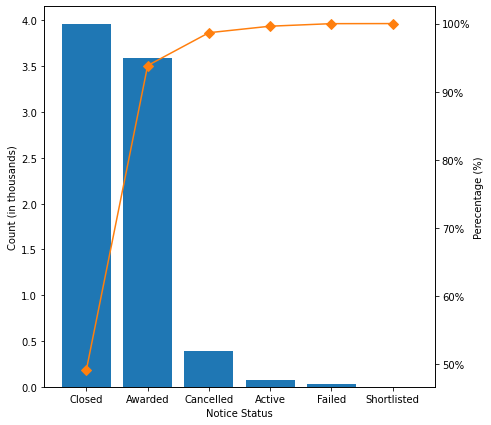

In [70]:
fig, ax = plt.subplots(figsize=(7,7))
ax.bar(df_pareto['Notice Status'], df_pareto['Count']/1000, color="C0")
ax2 = ax.twinx()
ax2.plot(df_pareto['Notice Status'], df_pareto['cumpercentage'], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y")
ax2.tick_params(axis="y")
ax.set_xlabel('Notice Status')
ax.set_ylabel('Count (in thousands)')
ax2.set_ylabel('Perecentage (%)')
plt.show()

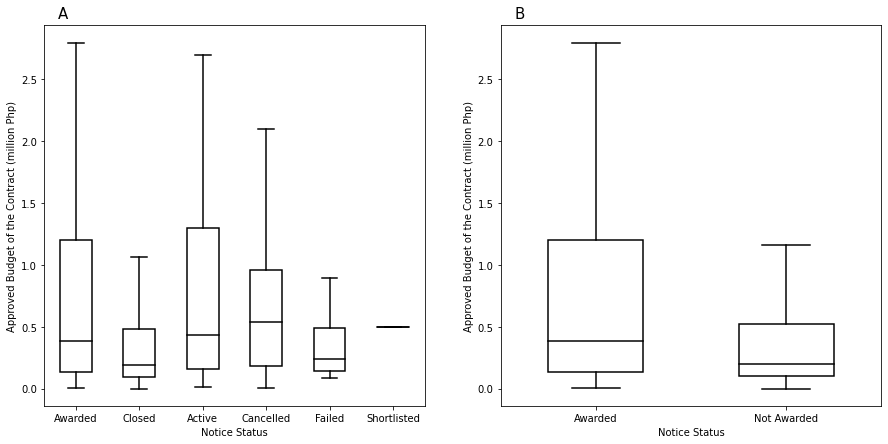

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

a = sns.boxplot(x="Notice Status", y="Approved Budget of the Contract", data=df_numeric_eda, color='white', width=.5, ax=ax[0], showfliers=False)
a.set_xticklabels(a.get_xticklabels())
a.set_ylabel('Approved Budget of the Contract (million Php)')
a.set_xlabel('Notice Status')
a.text(0.05, 1.03, 'A', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=15)
# iterate over boxes
for i,box in enumerate(a.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(5*i,5*(i+1)):
         a.lines[j].set_color('black')

b = sns.boxplot(x="is_Awarded", y="Approved Budget of the Contract", data=df_numeric_eda, color='white', showfliers=False, width=.5, ax=ax[1])
b.set_xticklabels(b.get_xticklabels())
b.set_ylabel('Approved Budget of the Contract (million Php)')
b.set_xlabel('Notice Status')
b.text(0.05, 1.03, 'B', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=15) 
# iterate over boxes
for i,box in enumerate(b.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(5*i,5*(i+1)):
         b.lines[j].set_color('black')

In [72]:
awarded_ABC = df_numeric_eda.loc[df_numeric_eda['is_Awarded']=='Awarded']['Approved Budget of the Contract']
not_awarded_ABC = df_numeric_eda.loc[df_numeric_eda['is_Awarded']=='Not Awarded']['Approved Budget of the Contract']

In [73]:
pg.ttest(not_awarded_ABC, awarded_ABC)

T          dof alternative         p-val           CI95%  \
T-test -7.230988  7869.112274   two-sided  5.245232e-13  [-1.15, -0.66]   

         cohen-d       BF10  power  
T-test  0.161019  5.004e+09    1.0

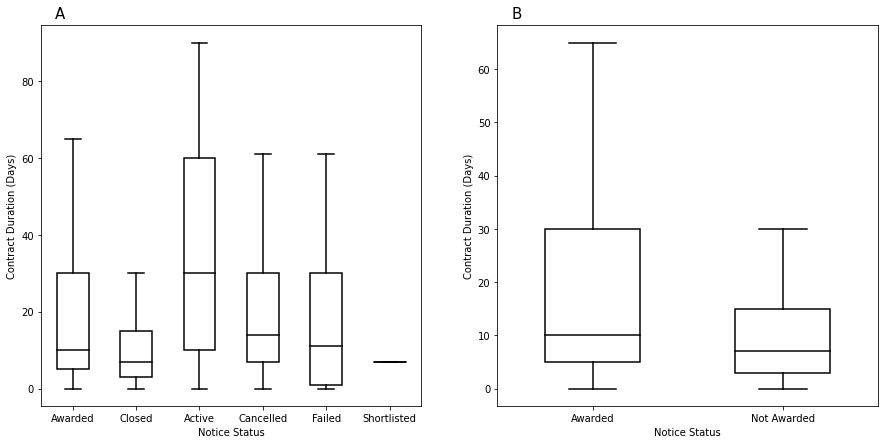

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

a = sns.boxplot(x="Notice Status", y="Contract Duration (Days)", data=df_numeric_eda, color='white', width=.5, ax=ax[0], showfliers=False)
a.set_xticklabels(a.get_xticklabels())
a.set_ylabel('Contract Duration (Days)')
a.set_xlabel('Notice Status')
a.text(0.05, 1.03, 'A', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=15)
# iterate over boxes
for i,box in enumerate(a.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(5*i,5*(i+1)):
         a.lines[j].set_color('black')

b = sns.boxplot(x="is_Awarded", y="Contract Duration (Days)", data=df_numeric_eda, color='white', showfliers=False, width=.5, ax=ax[1])
b.set_xticklabels(b.get_xticklabels())
b.set_ylabel('Contract Duration (Days)')
b.set_xlabel('Notice Status')
b.text(0.05, 1.03, 'B', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=15) 
# iterate over boxes
for i,box in enumerate(b.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(5*i,5*(i+1)):
         b.lines[j].set_color('black')

In [75]:
awarded_CD = df_numeric_eda.loc[df_numeric_eda['is_Awarded']=='Awarded']['Contract Duration (Days)']
not_awarded_CD = df_numeric_eda.loc[df_numeric_eda['is_Awarded']=='Not Awarded']['Contract Duration (Days)']

In [76]:
pg.ttest(not_awarded_CD, awarded_CD)

T         dof alternative         p-val           CI95%  \
T-test -9.556728  8023.24207   two-sided  1.581940e-21  [-4.77, -3.14]   

         cohen-d       BF10  power  
T-test  0.210647  1.224e+18    1.0

In [77]:
df_pareto_class = pd.DataFrame(df_numeric_eda.groupby('Classification').size().sort_values(ascending=False)).reset_index()
df_pareto_class.columns = ['Classification', 'Count']
df_pareto_class['cumpercentage'] = df_pareto_class['Count'].cumsum()/df_pareto_class['Count'].sum()*100

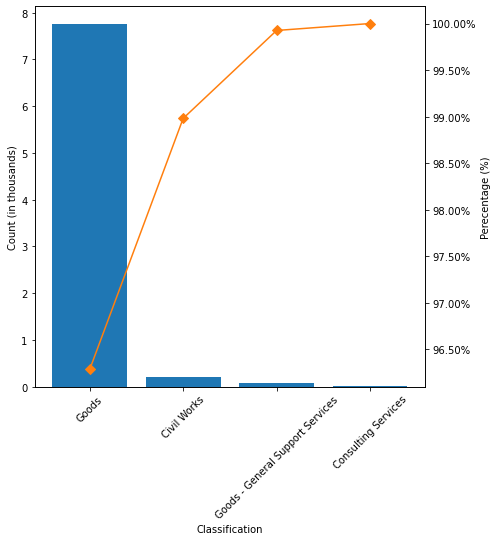

In [78]:
fig, ax = plt.subplots(figsize=(7,7))
ax.bar(df_pareto_class['Classification'], df_pareto_class['Count']/1000, color="C0")
ax.tick_params(axis='x', rotation=45)
ax2 = ax.twinx()
ax2.plot(df_pareto_class['Classification'], df_pareto_class['cumpercentage'], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax.tick_params(axis="y")
ax2.tick_params(axis="y")
ax.set_xlabel('Classification')
ax.set_ylabel('Count (in thousands)')
ax2.set_ylabel('Perecentage (%)')
plt.show()

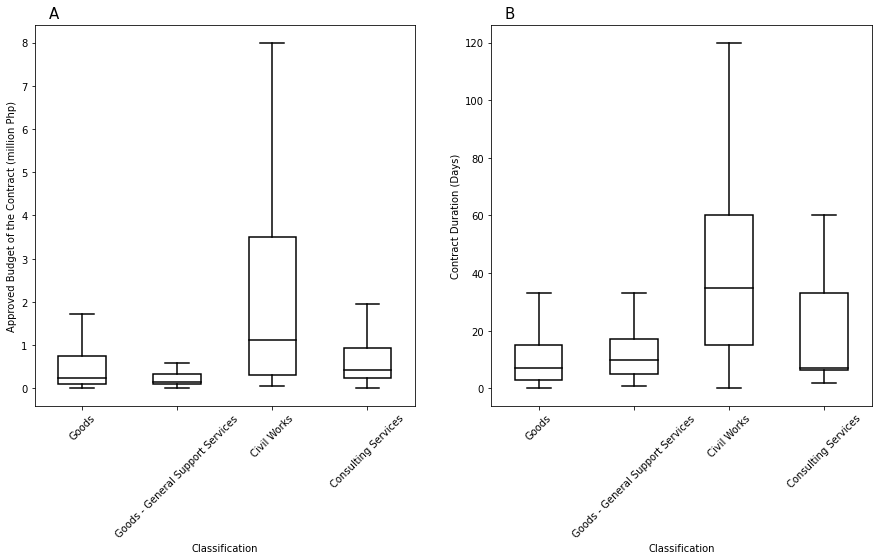

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

a = sns.boxplot(x="Classification", y="Approved Budget of the Contract", data=df_numeric_eda, color='white', width=.5, ax=ax[0], showfliers=False)
a.set_xticklabels(a.get_xticklabels(), rotation=45)
a.set_ylabel('Approved Budget of the Contract (million Php)')
a.set_xlabel('Classification')
a.text(0.05, 1.03, 'A', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=15)
# iterate over boxes
for i,box in enumerate(a.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(5*i,5*(i+1)):
         a.lines[j].set_color('black')

b = sns.boxplot(x="Classification", y="Contract Duration (Days)", data=df_numeric_eda, color='white', showfliers=False, width=.5, ax=ax[1])
b.set_xticklabels(b.get_xticklabels(), rotation=45)
b.set_ylabel('Contract Duration (Days)')
b.set_xlabel('Classification')
b.text(0.05, 1.03, 'B', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=15) 
# iterate over boxes
for i,box in enumerate(b.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(5*i,5*(i+1)):
         b.lines[j].set_color('black')

In [80]:
df_numeric_eda['Approved Budget of the Contract'] = df_numeric_eda['Approved Budget of the Contract']/1000

<ipython-input-80-428f5c378e0a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric_eda['Approved Budget of the Contract'] = df_numeric_eda['Approved Budget of the Contract']/1000


In [81]:
top_10_ABC_BC_eda = pd.DataFrame(df_numeric_eda.groupby(
    'Business Category')[
    'Approved Budget of the Contract'].sum().sort_values(
    ascending=False)[:10]).reset_index()
top_10_ABC_BC_eda

Business Category  Approved Budget of the Contract
0                                  Food Stuff                         2.643321
1  Medical Supplies and Laboratory Instrument                         1.319088
2                           Catering Services                         1.220783
3                               Grocery Items                         0.967156
4                         General Merchandise                         0.638163
5                       Construction Projects                         0.611765
6                         Drugs and Medicines                         0.509582
7                Medical and Dental Equipment                         0.411137
8                      Information Technology                         0.406627
9                       Rice Milling Services                         0.196833

In [85]:
top_10_ABC_BC_percent_eda = pd.DataFrame(df_numeric_eda.groupby(
    'Business Category')[
    'Approved Budget of the Contract'].sum().sort_values(
    ascending=False)[:10]*100/10.38394446179).reset_index()
top_10_ABC_BC_percent_eda

Business Category  Approved Budget of the Contract
0                                  Food Stuff                        25.455849
1  Medical Supplies and Laboratory Instrument                        12.703152
2                           Catering Services                        11.756450
3                               Grocery Items                         9.313955
4                         General Merchandise                         6.145672
5                       Construction Projects                         5.891450
6                         Drugs and Medicines                         4.907407
7                Medical and Dental Equipment                         3.959354
8                      Information Technology                         3.915920
9                       Rice Milling Services                         1.895551

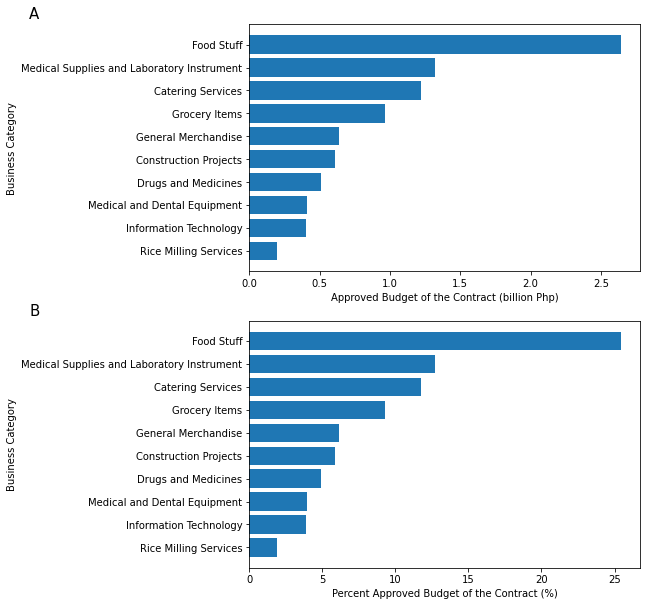

In [86]:
fig, ax = plt.subplots(2, 1, figsize=(7, 10))
ax[0].barh(top_10_ABC_BC_eda['Business Category'],
        top_10_ABC_BC_eda['Approved Budget of the Contract'], align='center')
ax[0].invert_yaxis()
ax[0].set_xlabel('Approved Budget of the Contract (billion Php)')
ax[0].set_ylabel('Business Category');
ax[0].text(-0.55, 2.24, 'A', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=15) 
ax[1].barh(top_10_ABC_BC_percent_eda['Business Category'],
        top_10_ABC_BC_percent_eda['Approved Budget of the Contract'], align='center')
ax[1].invert_yaxis()
ax[1].set_xlabel('Percent Approved Budget of the Contract (%)')
ax[1].set_ylabel('Business Category');
ax[1].text(-0.55, 1.04, 'B', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=15); 

## COVID-19 Contracts Text EDA

In [87]:
# extract contract description from columns text from cleaned data
desc = ['Notice Title', 'Item Name', 'Item Desc', 'Award Title',
        'Reason for Award']
df_covid_desc = df_covid[desc]

In [88]:
# check df_proc_2020_desc dataframe
df_covid_desc

Notice Title  \
110922                      PPE'S FOR COVID-19 PREVENTION   
110993  PROCUREMENT OF HAND SANITIZER(ALCOHOL) AND DES...   
110994  PROCUREMENT OF HAND SANITIZER(ALCOHOL) AND DES...   
114703     Emergency Purchase for the Prevention of COVID   
133320  TO BE USED FOR EMERGENCY MEDICAL SUPPLIES FOR ...   
...                                                   ...   
235953  Supply and Delivery of Catering Services for T...   
236074  Procurement of Acrylic Barrier for the use of ...   
236211  Supply and Delivery of Rapid Diagnostic Test K...   
236219  PROCUREMENT OF MEALS FOR THE LSI IN THE MUNICI...   
236327  Landscaping and Construction of Pavement, Fenc...   

                                                Item Name  \
110922                                   Medical Supplies   
110993                           PROCUREMENT OF DISPENSER   
110994                      PROCUREMENT OF HAND SANITIZER   
114703     Emergency Purchase for the Prevention of COVID   
133320                                               None   
...                                                   ...   
235953                                               None   
236074                                               None   
236211                                   Medical Supplies   
236219  MEALS FOR THE LSI IN THE MUNICIPAL ISOLATION C...   
236327                                               None   

                                                Item Desc  \
110922                      PPE'S FOR COVID-19 PREVENTION   
110993           FOR PREVENTION OF SPREAD  COVID 19 VIRUS   
110994           FOR PREVENTION OF SPREAD  COVID 19 VIRUS   
114703                                             MDRRMO   
133320                                               None   
...                                                   ...   
235953                                               None   
236074                                               None   
236211  1 COVID-19 Ag Test 5000 kits PANBIO COVID-19 ...   
236219  PROCUREMENT OF MEALS FOR THE LSI IN THE MUNICI...   
236327                                               None   

                                              Award Title  \
110922                                   Medical Supplies   
110993                           PROCUREMENT OF DISPENSER   
110994                      PROCUREMENT OF HAND SANITIZER   
114703     Emergency Purchase for the Prevention of COVID   
133320                                               None   
...                                                   ...   
235953                                               None   
236074                                               None   
236211  Supply and Delivery of Rapid Diagnostic Test K...   
236219  PROCUREMENT OF MEALS FOR THE LSI IN THE MUNICI...   
236327                                               None   

                            Reason for Award  
110922                                  LCRB  
110993                                  LCRB  
110994                                  LCRB  
114703         negotiated emergency purchase  
133320                           Not Awarded  
...                                      ...  
235953                           Not Awarded  
236074                           Not Awarded  
236211                Most Reliable Supplier  
236219  LOWEST CALCULATED AND RESPONSIVE BID  
236327                           Not Awarded  

[8047 rows x 5 columns]

In [89]:
# remove digits
df_covid_desc = df_covid_desc.fillna('')
df_covid_desc['Notice Title'] = df_covid_desc[
    'Notice Title'].str.replace('\d+', '').astype(str)
df_covid_desc['Item Name'] = df_covid_desc[
    'Item Name'].str.replace('\d+', '').astype(str)
df_covid_desc['Item Desc'] = df_covid_desc[
    'Item Desc'].str.replace('\d+', '').astype(str)
df_covid_desc['Award Title'] = df_covid_desc[
    'Award Title'].str.replace('\d+', '').astype(str)
df_covid_desc['Reason for Award'] = df_covid_desc[
    'Reason for Award'].str.replace('\d+', '').astype(str)

<ipython-input-89-c94f3d73ee29>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_covid_desc['Notice Title'] = df_covid_desc[
<ipython-input-89-c94f3d73ee29>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_covid_desc['Item Name'] = df_covid_desc[
<ipython-input-89-c94f3d73ee29>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df_covid_desc['Item Desc'] = df_covid_desc[
<ipython-input-89-c94f3d73ee29>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df_covid_desc['Award Title'] = df_covid_desc[
<ipython-input-89-c94f3d73ee29>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df_covid_desc['Reason for Award'] = df_covid_desc[


In [90]:
# remove stop words
df_covid_desc['Notice Title'] = df_covid_desc[
    'Notice Title'].apply(remove_stopwords)
df_covid_desc['Item Name'] = df_covid_desc['Item Name'].apply(remove_stopwords)
df_covid_desc['Item Desc'] = df_covid_desc['Item Desc'].apply(remove_stopwords)
df_covid_desc['Award Title'] = df_covid_desc[
    'Award Title'].apply(remove_stopwords)
df_covid_desc['Reason for Award'] = df_covid_desc[
    'Reason for Award'].apply(remove_stopwords)

In [91]:
# lemmatize each column
df_covid_desc['Notice Title'] = df_covid_desc[
    'Notice Title'].apply(lemmatize_text)
df_covid_desc['Item Name'] = df_covid_desc[
    'Item Name'].apply(lemmatize_text)
df_covid_desc['Item Desc'] = df_covid_desc[
    'Item Desc'].apply(lemmatize_text)
df_covid_desc['Award Title'] = df_covid_desc[
    'Award Title'].apply(lemmatize_text)
df_covid_desc['Reason for Award'] = df_covid_desc[
    'Reason for Award'].apply(lemmatize_text)

In [92]:
df_covid_desc

Notice Title  \
110922                              ppe covid- prevention   
110993  procurement hand sanitizer ( alcohol ) despens...   
110994  procurement hand sanitizer ( alcohol ) despens...   
114703                emergency purchase prevention covid   
133320     emergency medical supply covid- preparedness .   
...                                                   ...   
235953  supply delivery catering service ( ) hour , mo...   
236074  procurement acrylic barrier use rural health u...   
236211   supply delivery rapid diagnostic test kit covid-   
236219  procurement meal lsi municipal isolation covid...   
236327  landscaping construction pavement , fence emba...   

                                  Item Name  \
110922                       medical supply   
110993                procurement dispenser   
110994           procurement hand sanitizer   
114703  emergency purchase prevention covid   
133320                                        
...                                     ...   
235953                                        
236074                                        
236211                       medical supply   
236219   meal lsi municipal isolation covid   
236327                                        

                                                Item Desc  \
110922                              ppe covid- prevention   
110993                      prevention spread covid virus   
110994                      prevention spread covid virus   
114703                                             mdrrmo   
133320                                                      
...                                                   ...   
235953                                                      
236074                                                      
236211  covid- ag test kit panbio covid- ag rapid tes...   
236219  procurement meal lsi municipal isolation covid...   
236327                                                      

                                              Award Title  \
110922                                     medical supply   
110993                              procurement dispenser   
110994                         procurement hand sanitizer   
114703                emergency purchase prevention covid   
133320                                                      
...                                                   ...   
235953                                                      
236074                                                      
236211   supply delivery rapid diagnostic test kit covid-   
236219  procurement meal lsi municipal isolation covid...   
236327                                                      

                        Reason for Award  
110922                              lcrb  
110993                              lcrb  
110994                              lcrb  
114703     negotiated emergency purchase  
133320                           awarded  
...                                  ...  
235953                           awarded  
236074                           awarded  
236211                 reliable supplier  
236219  lowest calculated responsive bid  
236327                           awarded  

[8047 rows x 5 columns]

In [93]:
df_covid_desc['Combined_Contract_Details'] = df_covid_desc['Notice Title'] + ' ' + df_covid_desc['Item Name'] + ' ' + df_covid_desc['Item Desc'] + ' ' + df_covid_desc['Award Title']
df_covid_desc

Notice Title  \
110922                              ppe covid- prevention   
110993  procurement hand sanitizer ( alcohol ) despens...   
110994  procurement hand sanitizer ( alcohol ) despens...   
114703                emergency purchase prevention covid   
133320     emergency medical supply covid- preparedness .   
...                                                   ...   
235953  supply delivery catering service ( ) hour , mo...   
236074  procurement acrylic barrier use rural health u...   
236211   supply delivery rapid diagnostic test kit covid-   
236219  procurement meal lsi municipal isolation covid...   
236327  landscaping construction pavement , fence emba...   

                                  Item Name  \
110922                       medical supply   
110993                procurement dispenser   
110994           procurement hand sanitizer   
114703  emergency purchase prevention covid   
133320                                        
...                                     ...   
235953                                        
236074                                        
236211                       medical supply   
236219   meal lsi municipal isolation covid   
236327                                        

                                                Item Desc  \
110922                              ppe covid- prevention   
110993                      prevention spread covid virus   
110994                      prevention spread covid virus   
114703                                             mdrrmo   
133320                                                      
...                                                   ...   
235953                                                      
236074                                                      
236211  covid- ag test kit panbio covid- ag rapid tes...   
236219  procurement meal lsi municipal isolation covid...   
236327                                                      

                                              Award Title  \
110922                                     medical supply   
110993                              procurement dispenser   
110994                         procurement hand sanitizer   
114703                emergency purchase prevention covid   
133320                                                      
...                                                   ...   
235953                                                      
236074                                                      
236211   supply delivery rapid diagnostic test kit covid-   
236219  procurement meal lsi municipal isolation covid...   
236327                                                      

                        Reason for Award  \
110922                              lcrb   
110993                              lcrb   
110994                              lcrb   
114703     negotiated emergency purchase   
133320                           awarded   
...                                  ...   
235953                           awarded   
236074                           awarded   
236211                 reliable supplier   
236219  lowest calculated responsive bid   
236327                           awarded   

                                Combined_Contract_Details  
110922  ppe covid- prevention medical supply ppe covid...  
110993  procurement hand sanitizer ( alcohol ) despens...  
110994  procurement hand sanitizer ( alcohol ) despens...  
114703  emergency purchase prevention covid emergency ...  
133320  emergency medical supply covid- preparedness .     
...                                                   ...  
235953  supply delivery catering service ( ) hour , mo...  
236074  procurement acrylic barrier use rural health u...  
236211  supply delivery rapid diagnostic test kit covi...  
236219  procurement meal lsi municipal isolation covid...  
236327  landscaping construction pavement , fence emba...  

[8047 rows x 6 columns]

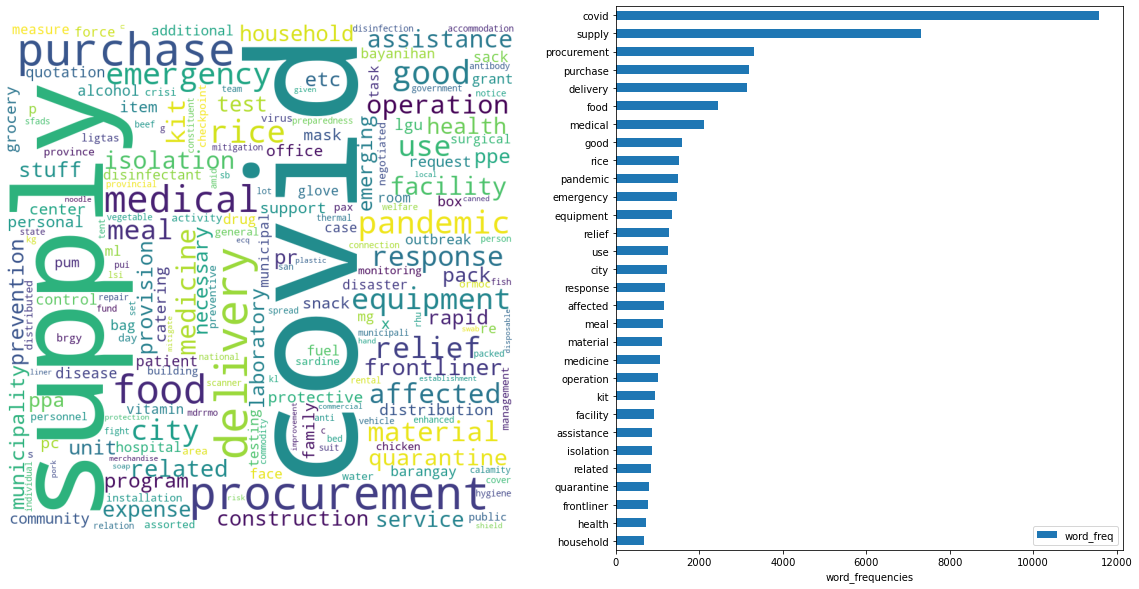

In [94]:
# create wordcloud
contract_details_text = ' '.join(df_covid_desc['Combined_Contract_Details'])
wordcloud_contract_details = WordCloud(
    width = 800, height = 800,
    background_color ='white',
    max_words=200,
    collocations = False).generate(contract_details_text)

# create word frequencies
wordcloud_freq_contract_details = WordCloud(collocations = False).process_text(contract_details_text)
dict_freq = dict(sorted(
    wordcloud_freq_contract_details.items(), key=lambda item: item[1], reverse=True))
top_30_freq = {k: dict_freq[k] for k in list(dict_freq)[:30]}
top_30_freq_df = pd.DataFrame.from_dict(
    top_30_freq, orient='index', columns=['word_freq'])

# generate plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(wordcloud_contract_details)
ax1.axis("off")
ax2 = top_30_freq_df.plot(kind='barh', ax=ax2)
ax2.set_xlabel('word_frequencies')
ax2.invert_yaxis()
plt.show()

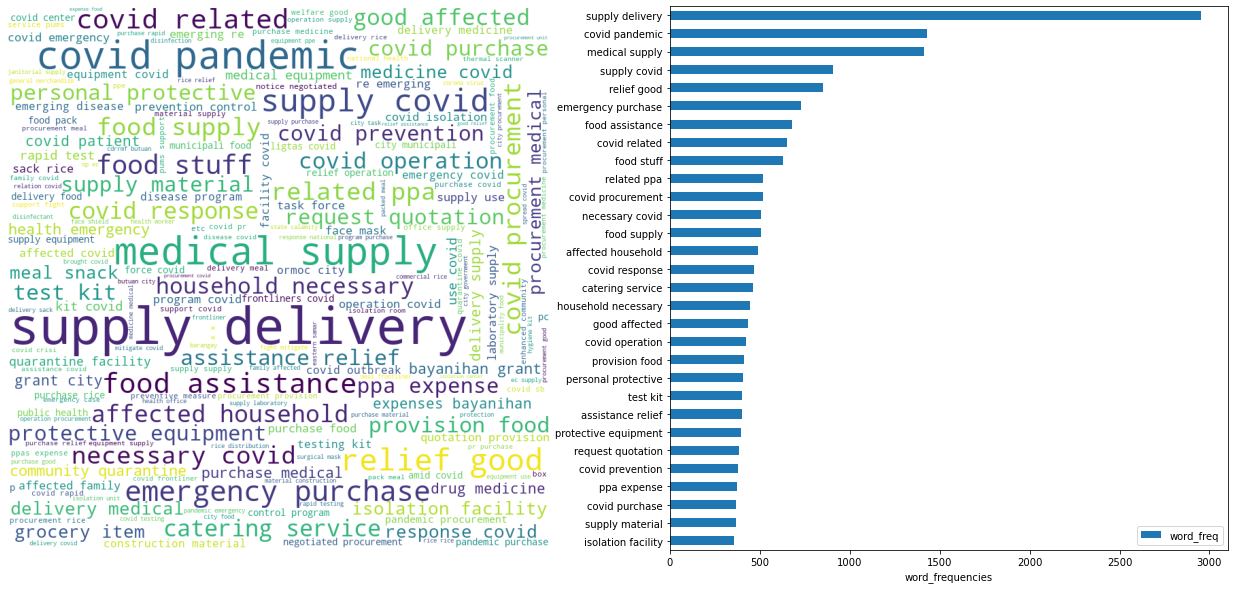

In [95]:
# create wordcloud
contract_details_text = ' '.join(df_covid_desc['Combined_Contract_Details'])
wordcloud_contract_details = WordCloud(
    width = 800, height = 800,
    background_color ='white',
    max_words=200,
    collocations = True).generate(contract_details_text)

# create word frequencies
wordcloud_freq_contract_details = WordCloud(collocations = True).process_text(contract_details_text)
dict_freq = dict(sorted(
    wordcloud_freq_contract_details.items(), key=lambda item: item[1], reverse=True))
top_30_freq = {k: dict_freq[k] for k in list(dict_freq)[:30]}
top_30_freq_df = pd.DataFrame.from_dict(
    top_30_freq, orient='index', columns=['word_freq'])

# generate plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(22,10))
ax1.imshow(wordcloud_contract_details)
ax1.axis("off")
ax2 = top_30_freq_df.plot(kind='barh', ax=ax2)
ax2.set_xlabel('word_frequencies')
ax2.invert_yaxis()
plt.show()

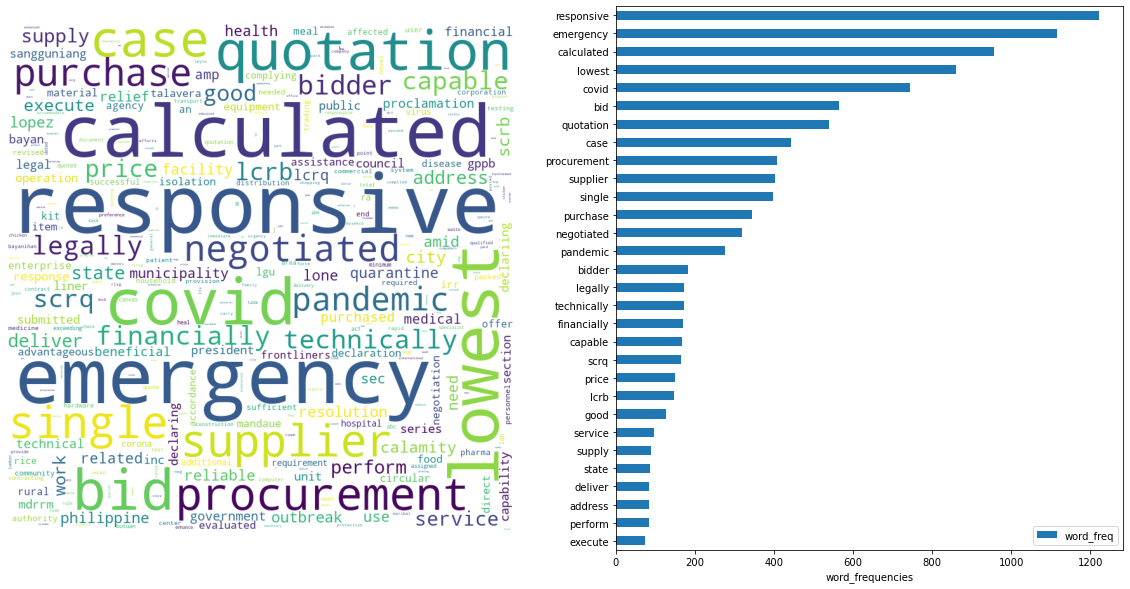

In [96]:
# create wordcloud
reason_for_award_text = ' '.join(df_covid_desc['Reason for Award'])
wordcloud_reason_for_award = WordCloud(
    width = 800, height = 800,
    background_color ='white',
    max_words=500,
    collocations = False, stopwords=['awarded']).generate(reason_for_award_text)

# create word frequencies
wordcloud_freq_reason_for_award = WordCloud(collocations = False, stopwords=['awarded']).process_text(reason_for_award_text)
dict_freq = dict(sorted(
    wordcloud_freq_reason_for_award.items(), key=lambda item: item[1], reverse=True))
top_30_freq = {k: dict_freq[k] for k in list(dict_freq)[:30]}
top_30_freq_df = pd.DataFrame.from_dict(
    top_30_freq, orient='index', columns=['word_freq'])

# generate plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(wordcloud_reason_for_award)
ax1.axis("off")
ax2 = top_30_freq_df.plot(kind='barh', ax=ax2)
ax2.set_xlabel('word_frequencies')
ax2.invert_yaxis()
plt.show()

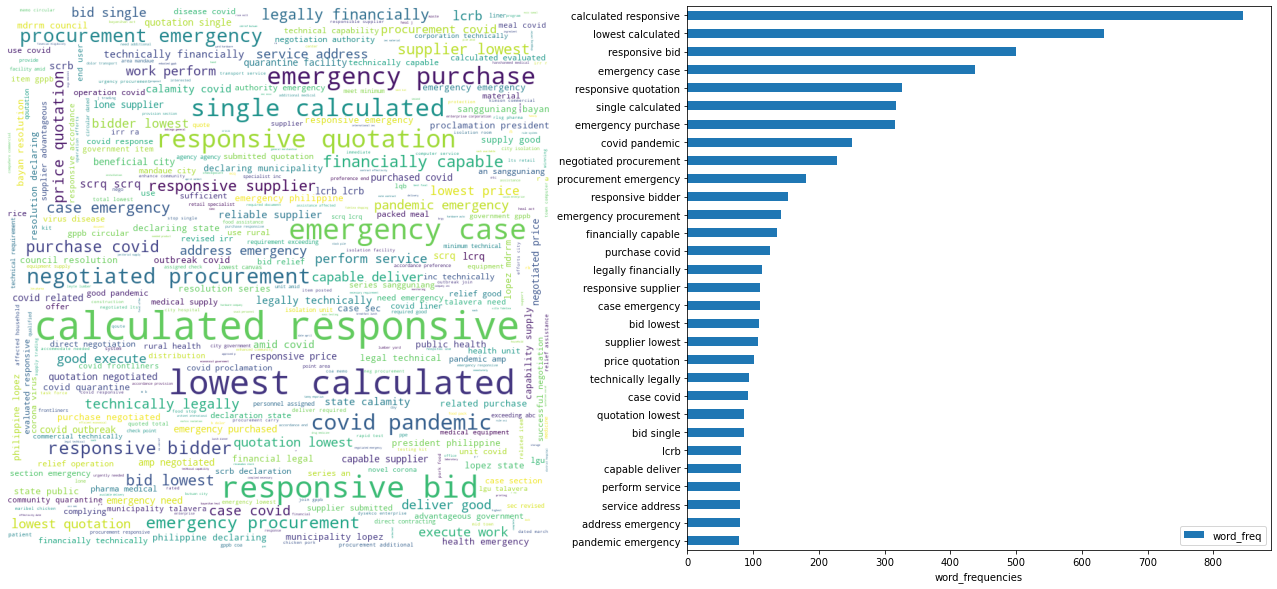

In [97]:
# create wordcloud
reason_for_award_text = ' '.join(df_covid_desc['Reason for Award'])
wordcloud_reason_for_award = WordCloud(
    width = 800, height = 800,
    background_color ='white',
    max_words=500,
    collocations = True, stopwords=['awarded']).generate(reason_for_award_text)

# create word frequencies
wordcloud_freq_reason_for_award = WordCloud(collocations = True,stopwords=['awarded']).process_text(reason_for_award_text)
dict_freq = dict(sorted(
    wordcloud_freq_reason_for_award.items(), key=lambda item: item[1], reverse=True))
top_30_freq = {k: dict_freq[k] for k in list(dict_freq)[:30]}
top_30_freq_df = pd.DataFrame.from_dict(
    top_30_freq, orient='index', columns=['word_freq'])

# generate plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(23,10))
ax1.imshow(wordcloud_reason_for_award)
ax1.axis("off")
ax2 = top_30_freq_df.plot(kind='barh', ax=ax2)
ax2.set_xlabel('word_frequencies')
ax2.invert_yaxis()
plt.show()

## Contracts with Negative Award-NTP (Days) Numeric EDA

In [126]:
df_negative = df_lgu_clean.loc[df_lgu_clean['Award-NTP (Days)'] < 0]
df_negative

Organization Name Reference ID  \
575                   MUNICIPALITY OF POTOTAN, ILOILO      6412660   
1216              MUNICIPALITY OF CABUGAO, ILOCOS SUR      6781486   
4455                MUNICIPALITY OF KABACAN, COTABATO      6784050   
5146                   CITY OF TAGUM, DAVAO DEL NORTE      6783359   
6339          CITY OF GENERAL SANTOS , SOUTH COTABATO      6785412   
...                                               ...          ...   
234115  MUNICIPALITY OF NABUNTURAN, COMPOSTELA VALLEY      7391367   
234557                             CITY OF CEBU, CEBU      7390618   
234558                             CITY OF CEBU, CEBU      7390618   
234602                             CITY OF CEBU, CEBU      7390668   
235387              CITY OF GINGOOG, MISAMIS ORIENTAL      7391332   

                      Solicitation No.  \
575                            6267368   
1216                     20-01-001Req.   
4455                   RFQ 2019-12-136   
5146                            20-45R   
6339    20CB-GSC-019 CATERING SERVICES   
...                                ...   
234115                  100-20-11-2811   
234557                     20-09-00555   
234558                     20-09-00555   
234602      18-09-00509 (Late Posting)   
235387                    20-20-02-025   

                                             Notice Title Publish Date  \
575     Purchase of Larvicide for the Prevention of De...   2020-01-02   
1216    Request for Quotation for the Purchase of Plan...   2020-01-03   
4455                       Meals & Snacks for SB Meetings   2020-01-06   
5146    Regular Bidding 14/Jan/2020 - Procurement of G...   2020-01-07   
6339                       20CB-GSC-019 CATERING SERVICES   2020-01-07   
...                                                   ...          ...   
234115  Reagents for MHO Laboratory (Direct Contractin...   2020-12-29   
234557  1,200 Bottles Aerosol Spray Fresh Scent 340 gr...   2020-12-30   
234558  1,200 Bottles Aerosol Spray Fresh Scent 340 gr...   2020-12-30   
234602  supply and delivery 50 pieces Access Valve 1/4...   2020-12-30   
235387  Purchase of Construction Materials & Supplies ...   2020-12-30   

       Classification                                     Notice Type  \
575             Goods  Invitation to Apply for Eligibility and to Bid   
1216            Goods               Notice for Negotiated Procurement   
4455            Goods                     Request for Quotation (RFQ)   
5146            Goods                         Invitation to Bid (ITB)   
6339            Goods                         Invitation to Bid (ITB)   
...               ...                                             ...   
234115          Goods  Invitation to Apply for Eligibility and to Bid   
234557          Goods                     Request for Quotation (RFQ)   
234558          Goods                     Request for Quotation (RFQ)   
234602          Goods                     Request for Quotation (RFQ)   
235387          Goods                     Request for Quotation (RFQ)   

                                        Business Category  \
575                       Chemicals and Chemical Products   
1216    Agricultural Products (Seeds, Seedlings, Plant...   
4455                                    Catering Services   
5146                                     Office Equipment   
6339                                    Catering Services   
...                                                   ...   
234115                  Laboratory Supplies and Equipment   
234557                    Chemicals and Chemical Products   
234558                    Chemicals and Chemical Products   
234602               Airconditioning Maintenance Services   
235387                Construction Materials and Supplies   

                             Funding Source  \
575     Government of the Philippines (GOP)   
1216    Government of the Philippines (GOP)   
4455    Government of the Philippines (GOP)   
514

In [127]:
df_negative_pair = df_negative[['Approved Budget of the Contract', 'Contract Duration (Days)', 'Award-NTP (Days)', 'Classification']]
df_negative_pair

Approved Budget of the Contract  Contract Duration (Days)  \
575                            140000.0                       7.0   
1216                           199000.0                       7.0   
4455                            52500.0                       7.0   
5146                           125500.0                      15.0   
6339                           992230.0                       1.0   
...                                 ...                       ...   
234115                          61583.0                       7.0   
234557                         656340.0                       0.0   
234558                         656340.0                       0.0   
234602                        1827241.4                       0.0   
235387                         294780.0                      15.0   

        Award-NTP (Days) Classification  
575                -77.0          Goods  
1216                -1.0          Goods  
4455               -14.0          Goods  
5146               -10.0          Goods  
6339                -5.0          Goods  
...                  ...            ...  
234115              -1.0          Goods  
234557             -39.0          Goods  
234558             -39.0          Goods  
234602            -756.0          Goods  
235387             -18.0          Goods  

[786 rows x 4 columns]

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


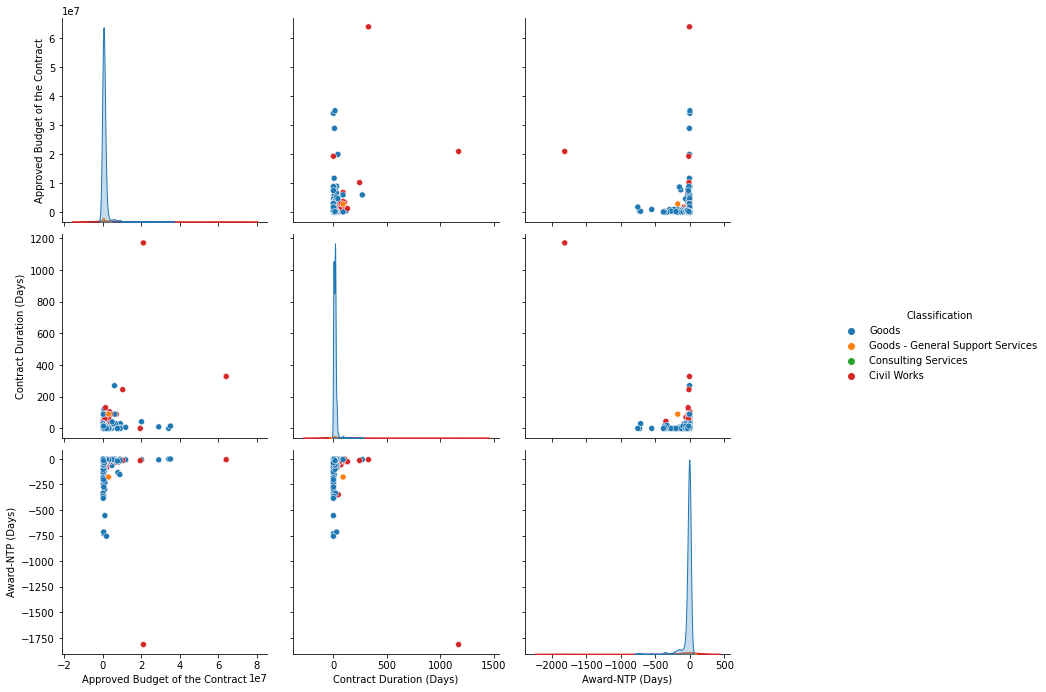

In [128]:
g = sns.pairplot(df_negative_pair, hue="Classification");
g.fig.set_size_inches(15,10)

In [129]:
numeric_eda = ['Organization Name', 'Classification', 'Notice Title', 'Notice Status', 'Approved Budget of the Contract', 'Business Category', 'Award-NTP (Days)', 'Contract Duration (Days)']
df_numeric_eda = df_negative[numeric_eda]
df_numeric_eda.loc[df_numeric_eda['Notice Status'] == 'Awarded', 'is_Awarded'] = 'Awarded'
df_numeric_eda.loc[df_numeric_eda['Notice Status'] != 'Awarded', 'is_Awarded'] = 'Not Awarded'
df_numeric_eda['Approved Budget of the Contract'] = df_numeric_eda['Approved Budget of the Contract']/1000000
df_numeric_eda

C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-129-405e95f7036b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

Organization Name Classification  \
575                   MUNICIPALITY OF POTOTAN, ILOILO          Goods   
1216              MUNICIPALITY OF CABUGAO, ILOCOS SUR          Goods   
4455                MUNICIPALITY OF KABACAN, COTABATO          Goods   
5146                   CITY OF TAGUM, DAVAO DEL NORTE          Goods   
6339          CITY OF GENERAL SANTOS , SOUTH COTABATO          Goods   
...                                               ...            ...   
234115  MUNICIPALITY OF NABUNTURAN, COMPOSTELA VALLEY          Goods   
234557                             CITY OF CEBU, CEBU          Goods   
234558                             CITY OF CEBU, CEBU          Goods   
234602                             CITY OF CEBU, CEBU          Goods   
235387              CITY OF GINGOOG, MISAMIS ORIENTAL          Goods   

                                             Notice Title Notice Status  \
575     Purchase of Larvicide for the Prevention of De...       Awarded   
1216    Request for Quotation for the Purchase of Plan...       Awarded   
4455                       Meals & Snacks for SB Meetings       Awarded   
5146    Regular Bidding 14/Jan/2020 - Procurement of G...       Awarded   
6339                       20CB-GSC-019 CATERING SERVICES        Closed   
...                                                   ...           ...   
234115  Reagents for MHO Laboratory (Direct Contractin...       Awarded   
234557  1,200 Bottles Aerosol Spray Fresh Scent 340 gr...       Awarded   
234558  1,200 Bottles Aerosol Spray Fresh Scent 340 gr...       Awarded   
234602  supply and delivery 50 pieces Access Valve 1/4...       Awarded   
235387  Purchase of Construction Materials & Supplies ...       Awarded   

        Approved Budget of the Contract  \
575                            0.140000   
1216                           0.199000   
4455                           0.052500   
5146                           0.125500   
6339                           0.992230   
...                                 ...   
234115                         0.061583   
234557                         0.656340   
234558                         0.656340   
234602                         1.827241   
235387                         0.294780   

                                        Business Category  Award-NTP (Days)  \
575                       Chemicals and Chemical Products             -77.0   
1216    Agricultural Products (Seeds, Seedlings, Plant...              -1.0   
4455                                    Catering Services             -14.0   
5146                                     Office Equipment             -10.0   
6339                                    Catering Services              -5.0   
...                                                   ...               ...   
234115                  Laboratory Supplies and Equipment              -1.0   
234557                    Chemicals and Chemical Products             -39.0   
234558                    Chemicals and Chemical Products             -39.0   
234602               Airconditioning Maintenance Services            -756.0   
235387                Construction Materials and Supplies             -18.0   

        Contract Duration (Days)   is_Awarded  
575                          7.0      Awarded  
1216                         7.0      Awarded  
4455                         7.0      Awarded  
5146                        15.0      Awarded  
6339                         1.0  Not Awarded  
...                          ...          ...  
234115                       7.0      Awarded  
234557                       0.0      Awarded  
234558                       0.0      Awarded  
234602                       0.0      Awarded  
235387                      15.0      Awarded  

[786 rows x 9 columns]

In [130]:
df_pareto = pd.DataFrame(df_numeric_eda.groupby('Notice Status').size().sort_values(ascending=False)).reset_index()
df_pareto.columns = ['Notice Status', 'Count']
df_pareto['cumpercentage'] = df_pareto['Count'].cumsum()/df_pareto['Count'].sum()*100

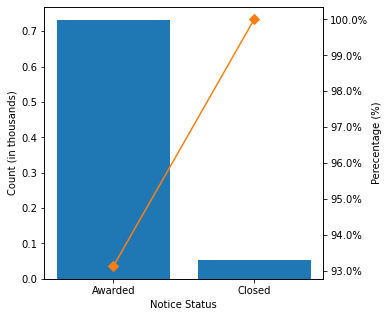

In [131]:
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(df_pareto['Notice Status'], df_pareto['Count']/1000, color="C0")
ax2 = ax.twinx()
ax2.plot(df_pareto['Notice Status'], df_pareto['cumpercentage'], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y")
ax2.tick_params(axis="y")
ax.set_xlabel('Notice Status')
ax.set_ylabel('Count (in thousands)')
ax2.set_ylabel('Perecentage (%)')
plt.show()

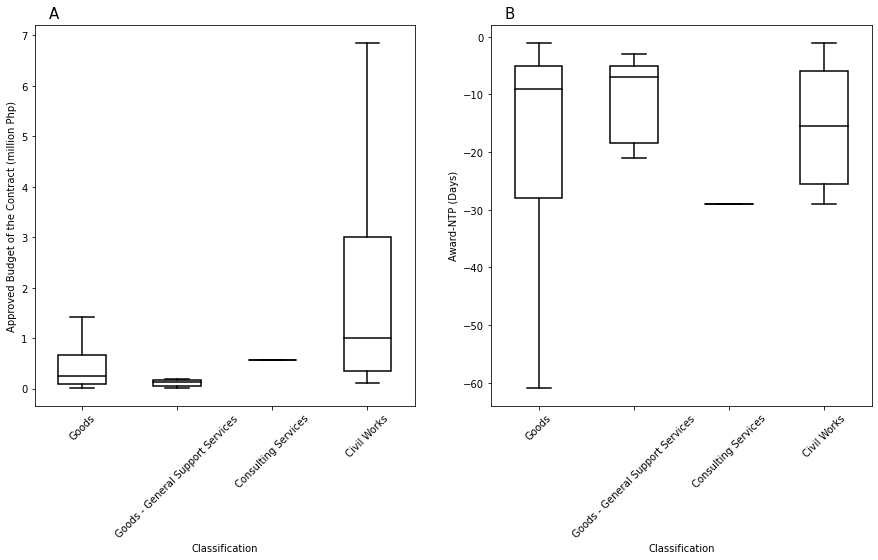

In [132]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

a = sns.boxplot(x="Classification", y="Approved Budget of the Contract", data=df_numeric_eda, color='white', width=.5, ax=ax[0], showfliers=False)
a.set_xticklabels(a.get_xticklabels(), rotation=45)
a.set_ylabel('Approved Budget of the Contract (million Php)')
a.set_xlabel('Classification')
a.text(0.05, 1.03, 'A', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=15)
# iterate over boxes
for i,box in enumerate(a.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(5*i,5*(i+1)):
         a.lines[j].set_color('black')

b = sns.boxplot(x="Classification", y="Award-NTP (Days)", data=df_numeric_eda, color='white', showfliers=False, width=.5, ax=ax[1])
b.set_xticklabels(b.get_xticklabels(), rotation=45)
b.set_ylabel('Award-NTP (Days)')
b.set_xlabel('Classification')
b.text(0.05, 1.03, 'B', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=15) 
# iterate over boxes
for i,box in enumerate(b.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(5*i,5*(i+1)):
         b.lines[j].set_color('black')

In [134]:
top_10_negative_days_eda = pd.DataFrame(df_numeric_eda.groupby(
    'Organization Name')[
    'Award-NTP (Days)'].min().sort_values(
    ascending=True)[:10]).reset_index()
top_10_negative_days_eda

Organization Name  Award-NTP (Days)
0                 MUNICIPALITY OF TUBA, BENGUET           -1815.0
1                            CITY OF CEBU, CEBU            -756.0
2                    PROVINCE OF AGUSAN DEL SUR            -731.0
3                   CITY OF NAGA, CAMARINES SUR            -715.0
4                    PROVINCE OF SOUTHERN LEYTE            -365.0
5         MUNICIPALITY OF STA. CRUZ, MARINDUQUE            -364.0
6  MUNICIPALITY OF MAMBURAO, OCCIDENTAL MINDORO            -364.0
7            MUNICIPALITY OF BURGOS, PANGASINAN            -349.0
8             MUNICIPALITY OF SUMILAO, BUKIDNON            -177.0
9                            PROVINCE OF ILOILO            -153.0

In [135]:
top_10_negative_count_eda = pd.DataFrame(df_numeric_eda.groupby(
    'Organization Name')[
    'Award-NTP (Days)'].size().sort_values(
    ascending=False)[:10]).reset_index()
top_10_negative_count_eda

Organization Name  Award-NTP (Days)
0                             CITY OF CEBU, CEBU               104
1                   CITY OF MALAYBALAY, BUKIDNON                97
2             MUNICIPALITY OF CALATRAVA, ROMBLON                83
3                 MUNICIPALITY OF ALBUERA, LEYTE                71
4     MUNICIPALITY OF LAPUYAN, ZAMBOANGA DEL SUR                33
5                   CITY OF DIGOS, DAVAO DEL SUR                31
6                  PROVINCE OF MOUNTAIN PROVINCE                29
7  MUNICIPALITY OF NABUNTURAN, COMPOSTELA VALLEY                24
8              CITY OF GINGOOG, MISAMIS ORIENTAL                20
9     MUNICIPALITY OF MONKAYO, COMPOSTELA VALLEY                12

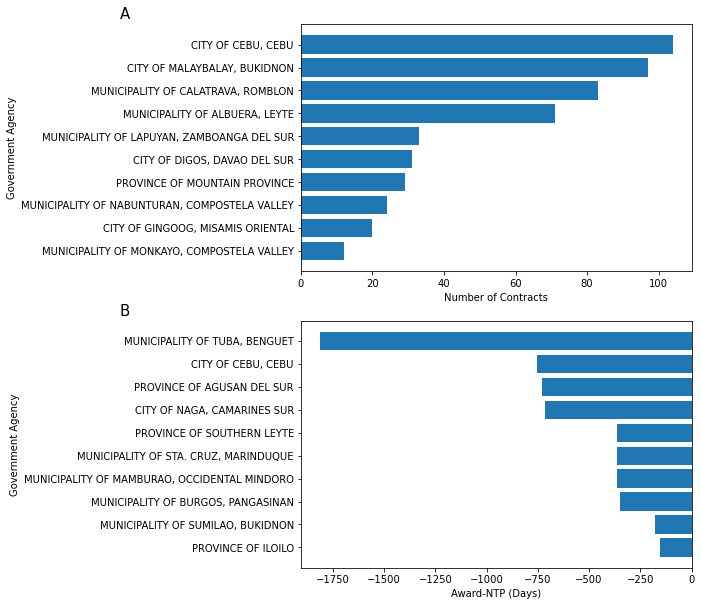

In [136]:
fig, ax = plt.subplots(2, 1, figsize=(7, 10))
ax[0].barh(top_10_negative_count_eda['Organization Name'],
        top_10_negative_count_eda['Award-NTP (Days)'], align='center')
ax[0].invert_yaxis()
ax[0].set_xlabel('Number of Contracts')
ax[0].set_ylabel('Government Agency');
ax[0].text(-0.45, 2.24, 'A', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=15) 
ax[1].barh(top_10_negative_days_eda['Organization Name'],
        top_10_negative_days_eda['Award-NTP (Days)'], align='center')
ax[1].invert_yaxis()
ax[1].set_xlabel('Award-NTP (Days)')
ax[1].set_ylabel('Government Agency');
ax[1].text(-0.45, 1.04, 'B', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=15); 

In [137]:
df_negative.loc[df_negative['Award-NTP (Days)'] < -700]

Organization Name Reference ID  \
25623   MUNICIPALITY OF TUBA, BENGUET      7094717   
135338     PROVINCE OF AGUSAN DEL SUR      7165583   
122169    CITY OF NAGA, CAMARINES SUR      7303375   
234602             CITY OF CEBU, CEBU      7390668   

                  Solicitation No.  \
25623          ITB No. 2020-06-002   
135338                 ADS-1815-20   
122169              20-1161-1031-1   
234602  18-09-00509 (Late Posting)   

                                             Notice Title Publish Date  \
25623                                   INFRA 2020-06-002   2020-07-09   
135338              Procurement of Information Technology   2020-08-13   
122169                    Supply and Delivery of Chlorine   2020-10-31   
234602  supply and delivery 50 pieces Access Valve 1/4...   2020-12-30   

       Classification                  Notice Type  \
25623     Civil Works      Invitation to Bid (ITB)   
135338          Goods      Invitation to Bid (ITB)   
122169          Goods  Request for Quotation (RFQ)   
234602          Goods  Request for Quotation (RFQ)   

                                        Business Category  \
25623                               Construction Projects   
135338                             Information Technology   
122169  Water and Waste Water Treatment Supply & Disposal   
234602               Airconditioning Maintenance Services   

                             Funding Source  \
25623   Government of the Philippines (GOP)   
135338  Government of the Philippines (GOP)   
122169  Government of the Philippines (GOP)   
234602  Government of the Philippines (GOP)   

                                       Funding Instrument  ...  \
25623                          General Appropriations Act  ...   
135338  Budget for the Contract Approved by the Sanggu...  ...   
122169  Budget for the Contract Approved by the Sanggu...  ...   
234602  Budget for the Contract Approved by the Sanggu...  ...   

                                   Reason for Award Award Status  \
25623   Single Lowest Calculated and Responsive Bid      Updated   
135338                        Lowest Calculated Bid      Updated   
122169                                         LCRB      Updated   
234602         supplier with lowest price quotation      Updated   

        Days Multiplier Contract Duration (Days)  Publish-NTP (Days)  \
25623                 1                   1171.0             -1766.0   
135338                1                      0.0              -626.0   
122169                1                     30.0                19.0   
234602                1                      0.0              -750.0   

       Publish-Award (Days)  Publish-Closing (Days) Award-NTP (Days)  Year  \
25623                  49.0                    19.0          -1815.0  2020   
135338                105.0                    20.0           -731.0  2020   
122169                734.0                     3.0           -715.0  2020   
234602                  6.0                     5.0           -756.0  2020   

        Quarter  
25623       3rd  
135338      3rd  
122169      4th  
234602      4th  

[4 rows x 48 columns]

In [106]:
# df_numeric_eda['Approved Budget of the Contract'] = df_numeric_eda['Approved Budget of the Contract']/1000

<ipython-input-106-428f5c378e0a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric_eda['Approved Budget of the Contract'] = df_numeric_eda['Approved Budget of the Contract']/1000


In [119]:
top_10_ABC_BC_eda = pd.DataFrame(df_numeric_eda.groupby(
    'Business Category')[
    'Approved Budget of the Contract'].sum().sort_values(
    ascending=False)[:10]).reset_index()
top_10_ABC_BC_eda

Business Category  Approved Budget of the Contract
0                       Construction Projects                       171.800957
1                                  Food Stuff                       122.462183
2                           Catering Services                        67.279516
3                         Drugs and Medicines                        59.529810
4  Medical Supplies and Laboratory Instrument                        52.947202
5         Construction Materials and Supplies                        41.511924
6                               Grocery Items                        18.103524
7                                    Garments                        17.194500
8                Hospital / Medical Equipment                        16.808400
9                         General Merchandise                        16.606324

In [121]:
top_10_ABC_BC_percent_eda = pd.DataFrame(df_numeric_eda.groupby(
    'Business Category')[
    'Approved Budget of the Contract'].sum().sort_values(
    ascending=False)[:10]*100/720.8407966799999).reset_index()
top_10_ABC_BC_percent_eda

Business Category  Approved Budget of the Contract
0                       Construction Projects                        23.833412
1                                  Food Stuff                        16.988797
2                           Catering Services                         9.333478
3                         Drugs and Medicines                         8.258385
4  Medical Supplies and Laboratory Instrument                         7.345201
5         Construction Materials and Supplies                         5.758820
6                               Grocery Items                         2.511446
7                                    Garments                         2.385339
8                Hospital / Medical Equipment                         2.331777
9                         General Merchandise                         2.303744

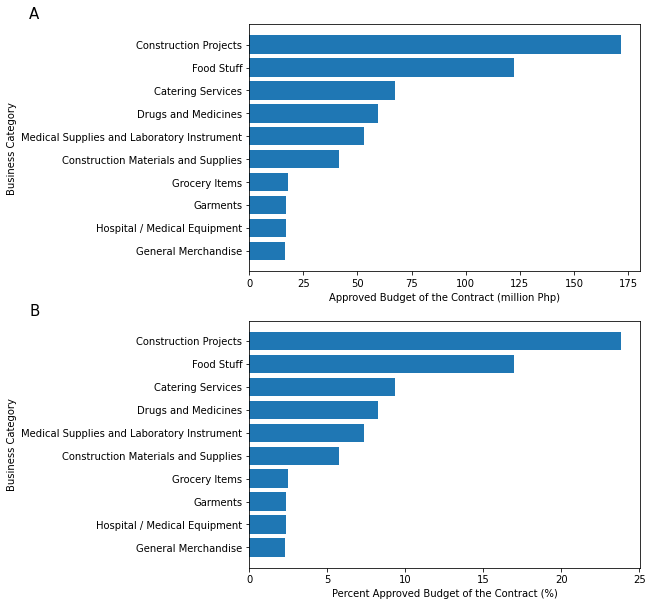

In [122]:
fig, ax = plt.subplots(2, 1, figsize=(7, 10))
ax[0].barh(top_10_ABC_BC_eda['Business Category'],
        top_10_ABC_BC_eda['Approved Budget of the Contract'], align='center')
ax[0].invert_yaxis()
ax[0].set_xlabel('Approved Budget of the Contract (million Php)')
ax[0].set_ylabel('Business Category');
ax[0].text(-0.55, 2.24, 'A', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=15) 
ax[1].barh(top_10_ABC_BC_percent_eda['Business Category'],
        top_10_ABC_BC_percent_eda['Approved Budget of the Contract'], align='center')
ax[1].invert_yaxis()
ax[1].set_xlabel('Percent Approved Budget of the Contract (%)')
ax[1].set_ylabel('Business Category');
ax[1].text(-0.55, 1.04, 'B', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=15); 

## Contracts with Negative Award-NTP (Days) Text EDA

In [264]:
# extract contract description from columns text from cleaned data
desc = ['Notice Title', 'Item Name', 'Item Desc', 'Award Title',
        'Reason for Award']
df_negative_desc = df_negative[desc]

In [265]:
# check df_proc_2020_desc dataframe
df_negative_desc

Notice Title  \
575     Purchase of Larvicide for the Prevention of De...   
1216    Request for Quotation for the Purchase of Plan...   
4455                       Meals & Snacks for SB Meetings   
5146    Regular Bidding 14/Jan/2020 - Procurement of G...   
6339                       20CB-GSC-019 CATERING SERVICES   
...                                                   ...   
234115  Reagents for MHO Laboratory (Direct Contractin...   
234557  1,200 Bottles Aerosol Spray Fresh Scent 340 gr...   
234558  1,200 Bottles Aerosol Spray Fresh Scent 340 gr...   
234602  supply and delivery 50 pieces Access Valve 1/4...   
235387  Purchase of Construction Materials & Supplies ...   

                                            Item Name  \
575                                         larvicide   
1216                                           plants   
4455                                   Meals & Snacks   
5146                              IT/OFFICE EQUIPMENT   
6339                                  20CB-GSC-019 B5   
...                                               ...   
234115                            Laboratory Supplies   
234557                              Chemical Products   
234558                                 Medical Supply   
234602               Access Valve 1/4 and other items   
235387  Purchase of Construction Materials & Supplies   

                                                Item Desc  \
575     larvicide for aedes Aegypti Mosquito Calcium H...   
1216                                      assorted plants   
4455                       Meals & Snacks for SB Meetings   
5146    IT/OFFICE EQUIPMENT (PRINTER & SSD SATA III) F...   
6339                        1 MEAL & 2 SNACKS W/OUT VENUE   
...                                                   ...   
234115                        Reagents for MHO Laboratory   
234557  Aerosol Spray Fresh Scent 340 grams and other ...   
234558  Hospital Gauze Roll 40/40 28x24 36"x100 yard t...   
234602                   Access Valve 1/4 and other items   
235387  For "Revised" Construction of Multi-Purpose Ha...   

                                              Award Title  \
575     Purchase of Larvicide for the Prevention of De...   
1216                                               plants   
4455                                       Meals & Snacks   
5146                                  IT/OFFICE EQUIPMENT   
6339                                      20CB-GSC-019 B5   
...                                                   ...   
234115  Reagents for MHO Laboratory (Direct Contractin...   
234557                                  Chemical Products   
234558                                     Medical Supply   
234602                   Access Valve 1/4 and other items   
235387      Purchase of Construction Materials & Supplies   

                                         Reason for Award  
575                                     Exclussive Dealer  
1216                              small value procurement  
4455                   Lowest Calculated & Responsive Bid  
5146                                                 LCRB  
6339                                                 LCRB  
...                                                   ...  
234115  Legally, Technically and Financially Capable S...  
234557               Supplier with Lowest Price Quotation  
234558               Supplier with Lowest Price Quotation  
234602               supplier with lowest price quotation  
235387                                               LCRB  

[786 rows x 5 columns]

In [266]:
# remove digits
df_negative_desc = df_negative_desc.fillna('')
df_negative_desc['Notice Title'] = df_negative_desc[
    'Notice Title'].str.replace('\d+', '').astype(str)
df_negative_desc['Item Name'] = df_negative_desc[
    'Item Name'].str.replace('\d+', '').astype(str)
df_negative_desc['Item Desc'] = df_negative_desc[
    'Item Desc'].str.replace('\d+', '').astype(str)
df_negative_desc['Award Title'] = df_negative_desc[
    'Award Title'].str.replace('\d+', '').astype(str)
df_negative_desc['Reason for Award'] = df_negative_desc[
    'Reason for Award'].str.replace('\d+', '').astype(str)

<ipython-input-266-4ec40ff8d9ac>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_negative_desc['Notice Title'] = df_negative_desc[
<ipython-input-266-4ec40ff8d9ac>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_negative_desc['Item Name'] = df_negative_desc[
<ipython-input-266-4ec40ff8d9ac>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df_negative_desc['Item Desc'] = df_negative_desc[
<ipython-input-266-4ec40ff8d9ac>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df_negative_desc['Award Title'] = df_negative_desc[
<ipython-input-266-4ec40ff8d9ac>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df_negative_desc['Reason for Award'] = df_negative_desc[


In [267]:
# remove stop words
df_negative_desc['Notice Title'] = df_negative_desc[
    'Notice Title'].apply(remove_stopwords)
df_negative_desc['Item Name'] = df_negative_desc['Item Name'].apply(remove_stopwords)
df_negative_desc['Item Desc'] = df_negative_desc['Item Desc'].apply(remove_stopwords)
df_negative_desc['Award Title'] = df_negative_desc[
    'Award Title'].apply(remove_stopwords)
df_negative_desc['Reason for Award'] = df_negative_desc[
    'Reason for Award'].apply(remove_stopwords)

In [268]:
# lemmatize each column
df_negative_desc['Notice Title'] = df_negative_desc[
    'Notice Title'].apply(lemmatize_text)
df_negative_desc['Item Name'] = df_negative_desc[
    'Item Name'].apply(lemmatize_text)
df_negative_desc['Item Desc'] = df_negative_desc[
    'Item Desc'].apply(lemmatize_text)
df_negative_desc['Award Title'] = df_negative_desc[
    'Award Title'].apply(lemmatize_text)
df_negative_desc['Reason for Award'] = df_negative_desc[
    'Reason for Award'].apply(lemmatize_text)

In [269]:
df_negative_desc

Notice Title  \
575     purchase larvicide prevention dengue hemorragi...   
1216         request quotation purchase plant landscaping   
4455                              meal & snack sb meeting   
5146    regular bidding /jan/ - procurement good offic...   
6339                             cb-gsc- catering service   
...                                                   ...   
234115  reagent mho laboratory ( direct contracting ex...   
234557       , bottle aerosol spray fresh scent gram item   
234558       , bottle aerosol spray fresh scent gram item   
234602          supply delivery piece access valve / item   
235387  purchase construction material & supply revise...   

                                      Item Name  \
575                                   larvicide   
1216                                      plant   
4455                               meal & snack   
5146                        it/office equipment   
6339                                  cb-gsc- b   
...                                         ...   
234115                        laboratory supply   
234557                         chemical product   
234558                           medical supply   
234602                      access valve / item   
235387  purchase construction material & supply   

                                                Item Desc  \
575     larvicide aedes aegypti mosquito calcium hydro...   
1216                                       assorted plant   
4455                              meal & snack sb meeting   
5146    it/office equipment ( printer & ssd sata iii )...   
6339                             meal & snack w/out venue   
...                                                   ...   
234115                             reagent mho laboratory   
234557                aerosol spray fresh scent gram item   
234558              hospital gauze roll / x `` x yard ply   
234602                                access valve / item   
235387  `` revised '' construction multi-purpose hall ...   

                                              Award Title  \
575     purchase larvicide prevention dengue hemorragi...   
1216                                                plant   
4455                                         meal & snack   
5146                                  it/office equipment   
6339                                            cb-gsc- b   
...                                                   ...   
234115  reagent mho laboratory ( direct contracting ex...   
234557                                   chemical product   
234558                                     medical supply   
234602                                access valve / item   
235387            purchase construction material & supply   

                                         Reason for Award  
575                                     exclussive dealer  
1216                              small value procurement  
4455                   lowest calculated & responsive bid  
5146                                                 lcrb  
6339                                                 lcrb  
...                                                   ...  
234115  legally , technically financially capable supp...  
234557                    supplier lowest price quotation  
234558                    supplier lowest price quotation  
234602                    supplier lowest price quotation  
235387                                               lcrb  

[786 rows x 5 columns]

In [270]:
df_negative_desc['Combined_Contract_Details'] = df_negative_desc['Notice Title'] + ' ' + df_negative_desc['Item Name'] + ' ' + df_negative_desc['Item Desc'] + ' ' + df_negative_desc['Award Title']
df_negative_desc

Notice Title  \
575     purchase larvicide prevention dengue hemorragi...   
1216         request quotation purchase plant landscaping   
4455                              meal & snack sb meeting   
5146    regular bidding /jan/ - procurement good offic...   
6339                             cb-gsc- catering service   
...                                                   ...   
234115  reagent mho laboratory ( direct contracting ex...   
234557       , bottle aerosol spray fresh scent gram item   
234558       , bottle aerosol spray fresh scent gram item   
234602          supply delivery piece access valve / item   
235387  purchase construction material & supply revise...   

                                      Item Name  \
575                                   larvicide   
1216                                      plant   
4455                               meal & snack   
5146                        it/office equipment   
6339                                  cb-gsc- b   
...                                         ...   
234115                        laboratory supply   
234557                         chemical product   
234558                           medical supply   
234602                      access valve / item   
235387  purchase construction material & supply   

                                                Item Desc  \
575     larvicide aedes aegypti mosquito calcium hydro...   
1216                                       assorted plant   
4455                              meal & snack sb meeting   
5146    it/office equipment ( printer & ssd sata iii )...   
6339                             meal & snack w/out venue   
...                                                   ...   
234115                             reagent mho laboratory   
234557                aerosol spray fresh scent gram item   
234558              hospital gauze roll / x `` x yard ply   
234602                                access valve / item   
235387  `` revised '' construction multi-purpose hall ...   

                                              Award Title  \
575     purchase larvicide prevention dengue hemorragi...   
1216                                                plant   
4455                                         meal & snack   
5146                                  it/office equipment   
6339                                            cb-gsc- b   
...                                                   ...   
234115  reagent mho laboratory ( direct contracting ex...   
234557                                   chemical product   
234558                                     medical supply   
234602                                access valve / item   
235387            purchase construction material & supply   

                                         Reason for Award  \
575                                     exclussive dealer   
1216                              small value procurement   
4455                   lowest calculated & responsive bid   
5146                                                 lcrb   
6339                                                 lcrb   
...                                                   ...   
234115  legally , technically financially capable supp...   
234557                    supplier lowest price quotation   
234558                    supplier lowest price quotation   
234602                    supplier lowest price quotation   
235387                                               lcrb   

                                Combined_Contract_Details  
575     purchase larvicide prevention dengue hemorragi...  
1216    request quotation purchase plant landscaping p...  
4455    meal & snack sb meeting meal & snack meal & sn...  
5146    regular bidding /jan/ - procurement good offic...  
6339    cb-gsc- catering service cb-gsc- b meal & snac...  
...                                                   ...  
234115  reagent mho laboratory ( direct contracting ex...  
234557  , bottle aer

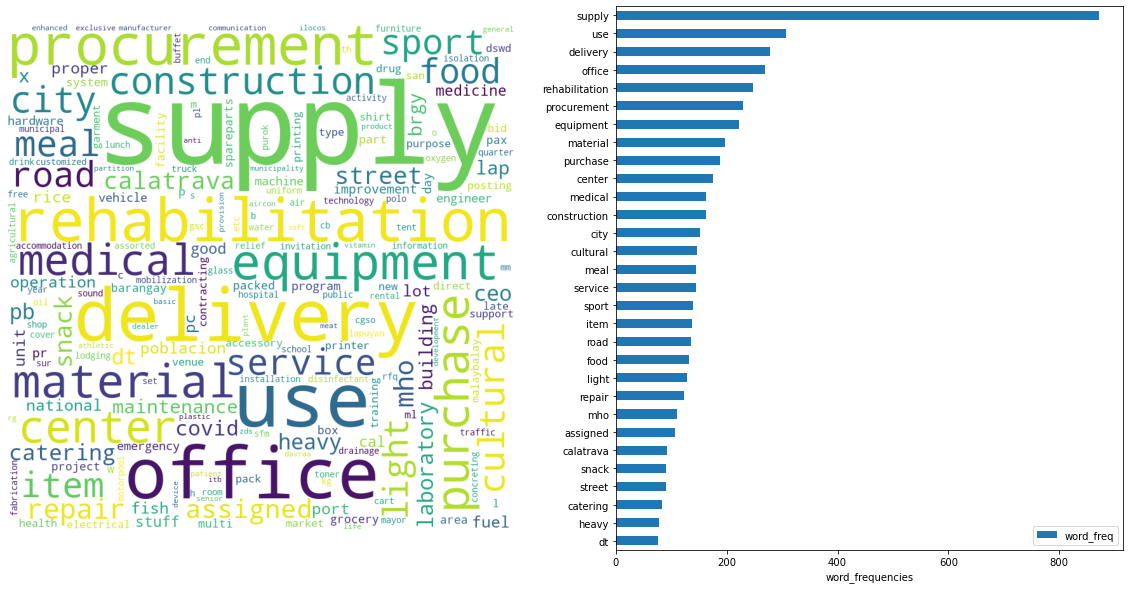

In [271]:
# create wordcloud
contract_details_text = ' '.join(df_negative_desc['Combined_Contract_Details'])
wordcloud_contract_details = WordCloud(
    width = 800, height = 800,
    background_color ='white',
    max_words=200,
    collocations = False).generate(contract_details_text)

# create word frequencies
wordcloud_freq_contract_details = WordCloud(collocations = False).process_text(contract_details_text)
dict_freq = dict(sorted(
    wordcloud_freq_contract_details.items(), key=lambda item: item[1], reverse=True))
top_30_freq = {k: dict_freq[k] for k in list(dict_freq)[:30]}
top_30_freq_df = pd.DataFrame.from_dict(
    top_30_freq, orient='index', columns=['word_freq'])

# generate plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(wordcloud_contract_details)
ax1.axis("off")
ax2 = top_30_freq_df.plot(kind='barh', ax=ax2)
ax2.set_xlabel('word_frequencies')
ax2.invert_yaxis()
plt.show()

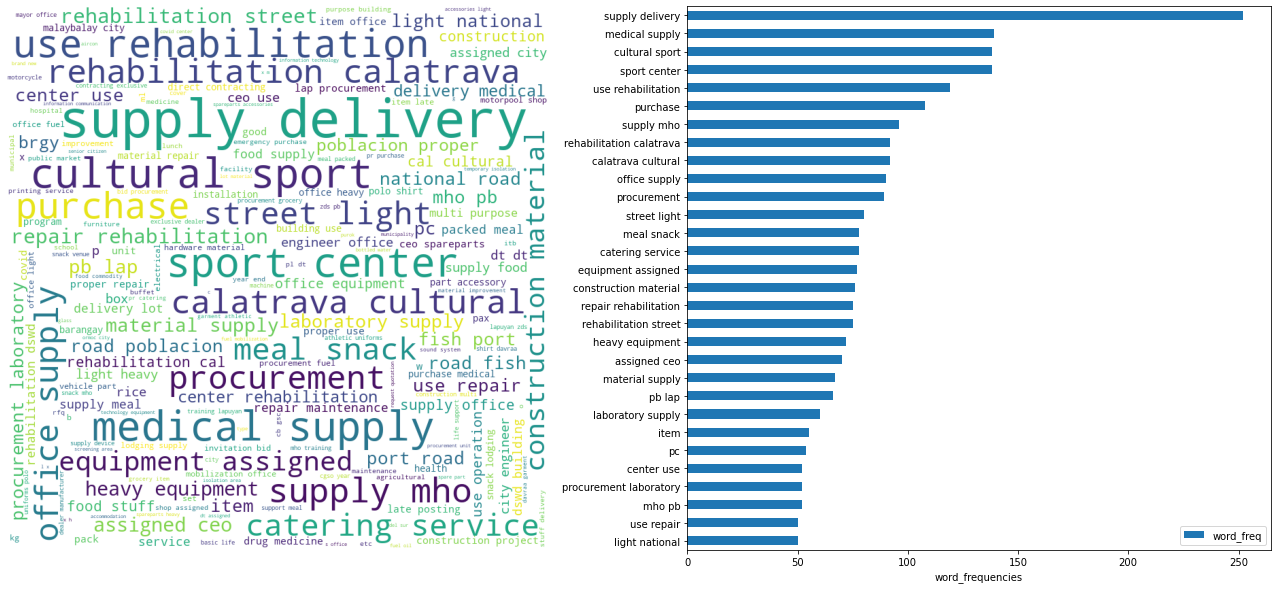

In [273]:
# create wordcloud
contract_details_text = ' '.join(df_negative_desc['Combined_Contract_Details'])
wordcloud_contract_details = WordCloud(
    width = 800, height = 800,
    background_color ='white',
    max_words=200,
    collocations = True).generate(contract_details_text)

# create word frequencies
wordcloud_freq_contract_details = WordCloud(collocations = True).process_text(contract_details_text)
dict_freq = dict(sorted(
    wordcloud_freq_contract_details.items(), key=lambda item: item[1], reverse=True))
top_30_freq = {k: dict_freq[k] for k in list(dict_freq)[:30]}
top_30_freq_df = pd.DataFrame.from_dict(
    top_30_freq, orient='index', columns=['word_freq'])

# generate plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(23,10))
ax1.imshow(wordcloud_contract_details)
ax1.axis("off")
ax2 = top_30_freq_df.plot(kind='barh', ax=ax2)
ax2.set_xlabel('word_frequencies')
ax2.invert_yaxis()
plt.show()

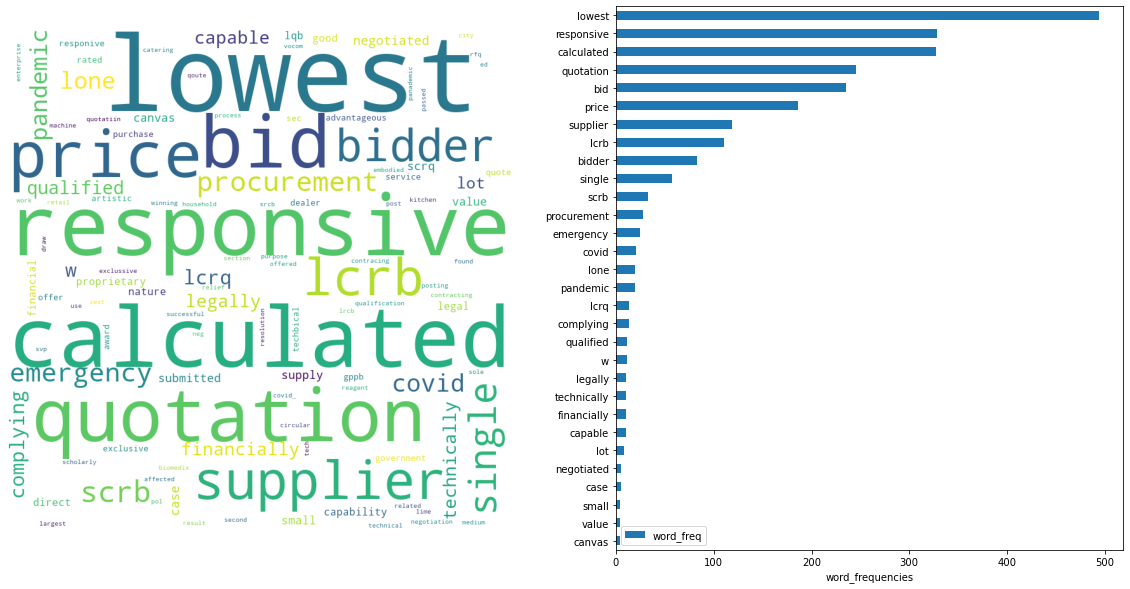

In [274]:
# create wordcloud
reason_for_award_text = ' '.join(df_negative_desc['Reason for Award'])
wordcloud_reason_for_award = WordCloud(
    width = 800, height = 800,
    background_color ='white',
    max_words=500,
    collocations = False, stopwords=['awarded']).generate(reason_for_award_text)

# create word frequencies
wordcloud_freq_reason_for_award = WordCloud(collocations = False, stopwords=['awarded']).process_text(reason_for_award_text)
dict_freq = dict(sorted(
    wordcloud_freq_reason_for_award.items(), key=lambda item: item[1], reverse=True))
top_30_freq = {k: dict_freq[k] for k in list(dict_freq)[:30]}
top_30_freq_df = pd.DataFrame.from_dict(
    top_30_freq, orient='index', columns=['word_freq'])

# generate plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(wordcloud_reason_for_award)
ax1.axis("off")
ax2 = top_30_freq_df.plot(kind='barh', ax=ax2)
ax2.set_xlabel('word_frequencies')
ax2.invert_yaxis()
plt.show()

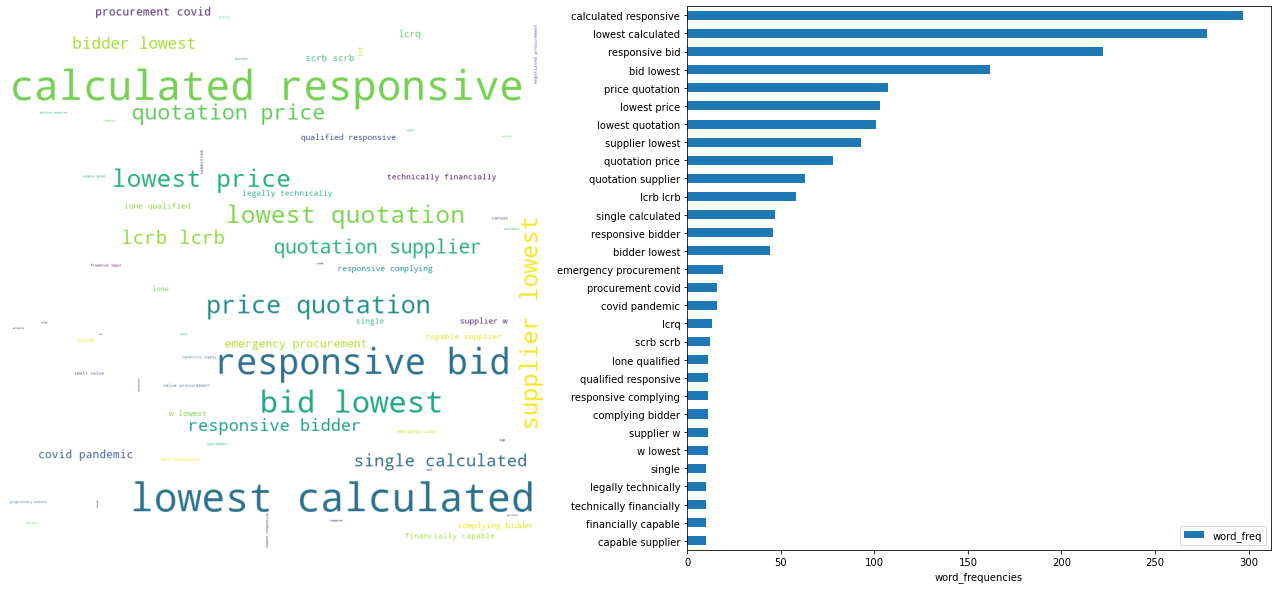

In [275]:
# create wordcloud
reason_for_award_text = ' '.join(df_negative_desc['Reason for Award'])
wordcloud_reason_for_award = WordCloud(
    width = 800, height = 800,
    background_color ='white',
    max_words=500,
    collocations = True, stopwords=['awarded']).generate(reason_for_award_text)

# create word frequencies
wordcloud_freq_reason_for_award = WordCloud(collocations = True,stopwords=['awarded']).process_text(reason_for_award_text)
dict_freq = dict(sorted(
    wordcloud_freq_reason_for_award.items(), key=lambda item: item[1], reverse=True))
top_30_freq = {k: dict_freq[k] for k in list(dict_freq)[:30]}
top_30_freq_df = pd.DataFrame.from_dict(
    top_30_freq, orient='index', columns=['word_freq'])

# generate plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(23,10))
ax1.imshow(wordcloud_reason_for_award)
ax1.axis("off")
ax2 = top_30_freq_df.plot(kind='barh', ax=ax2)
ax2.set_xlabel('word_frequencies')
ax2.invert_yaxis()
plt.show()